#NLU PROJECT

#Conll

In [ ]:
import re

"""
Modified version of https://pypi.org/project/conlleval/
"""


def stats():
    return {'cor': 0, 'hyp': 0, 'ref': 0}


def evaluate(ref, hyp, otag='O'):
    # evaluation for NLTK
    aligned = align_hyp(ref, hyp)
    return conlleval(aligned, otag=otag)


def align_hyp(ref, hyp):
    # align references and hypotheses for evaluation
    # add last element of token tuple in hyp to ref
    if len(ref) != len(hyp):
        raise ValueError("Size Mismatch: ref: {} & hyp: {}".format(len(ref), len(hyp)))

    out = []
    for i in range(len(ref)):
        if len(ref[i]) != len(hyp[i]):
            raise ValueError("Size Mismatch: ref: {} & hyp: {}".format(len(ref), len(hyp)))
        out.append([(*ref[i][j], hyp[i][j][-1]) for j in range(len(ref[i]))])
    return out


def conlleval(data, otag='O'):
    # token, segment & class level counts for TP, TP+FP, TP+FN
    tok = stats()
    seg = stats()
    cls = {}

    for sent in data:

        prev_ref = otag      # previous reference label
        prev_hyp = otag      # previous hypothesis label
        prev_ref_iob = None  # previous reference label IOB
        prev_hyp_iob = None  # previous hypothesis label IOB

        in_correct = False  # currently processed chunks is correct until now

        for token in sent:

            hyp_iob, hyp = parse_iob(token[-1])
            ref_iob, ref = parse_iob(token[-2])

            ref_e = is_eoc(ref, ref_iob, prev_ref, prev_ref_iob, otag)
            hyp_e = is_eoc(hyp, hyp_iob, prev_hyp, prev_hyp_iob, otag)

            ref_b = is_boc(ref, ref_iob, prev_ref, prev_ref_iob, otag)
            hyp_b = is_boc(hyp, hyp_iob, prev_hyp, prev_hyp_iob, otag)

            if not cls.get(ref) and ref:
                cls[ref] = stats()

            if not cls.get(hyp) and hyp:
                cls[hyp] = stats()

            # segment-level counts
            if in_correct:
                if ref_e and hyp_e and prev_hyp == prev_ref:
                    in_correct = False
                    seg['cor'] += 1
                    cls[prev_ref]['cor'] += 1

                elif ref_e != hyp_e or hyp != ref:
                    in_correct = False

            if ref_b and hyp_b and hyp == ref:
                in_correct = True

            if ref_b:
                seg['ref'] += 1
                cls[ref]['ref'] += 1

            if hyp_b:
                seg['hyp'] += 1
                cls[hyp]['hyp'] += 1

            # token-level counts
            if ref == hyp and ref_iob == hyp_iob:
                tok['cor'] += 1

            tok['ref'] += 1

            prev_ref = ref
            prev_hyp = hyp
            prev_ref_iob = ref_iob
            prev_hyp_iob = hyp_iob

        if in_correct:
            seg['cor'] += 1
            cls[prev_ref]['cor'] += 1

    return summarize(seg, cls)


def parse_iob(t):
    m = re.match(r'^([^-]*)-(.*)$', t)
    return m.groups() if m else (t, None)


def is_boc(lbl, iob, prev_lbl, prev_iob, otag='O'):
    """
    is beginning of a chunk

    supports: IOB, IOBE, BILOU schemes
        - {E,L} --> last
        - {S,U} --> unit

    :param lbl: current label
    :param iob: current iob
    :param prev_lbl: previous label
    :param prev_iob: previous iob
    :param otag: out-of-chunk label
    :return:
    """
    boc = False

    boc = True if iob in ['B', 'S', 'U'] else boc
    boc = True if iob in ['E', 'L'] and prev_iob in ['E', 'L', 'S', otag] else boc
    boc = True if iob == 'I' and prev_iob in ['S', 'L', 'E', otag] else boc

    boc = True if lbl != prev_lbl and iob != otag and iob != '.' else boc

    # these chunks are assumed to have length 1
    boc = True if iob in ['[', ']'] else boc

    return boc


def is_eoc(lbl, iob, prev_lbl, prev_iob, otag='O'):
    """
    is end of a chunk

    supports: IOB, IOBE, BILOU schemes
        - {E,L} --> last
        - {S,U} --> unit

    :param lbl: current label
    :param iob: current iob
    :param prev_lbl: previous label
    :param prev_iob: previous iob
    :param otag: out-of-chunk label
    :return:
    """
    eoc = False

    eoc = True if iob in ['E', 'L', 'S', 'U'] else eoc
    eoc = True if iob == 'B' and prev_iob in ['B', 'I'] else eoc
    eoc = True if iob in ['S', 'U'] and prev_iob in ['B', 'I'] else eoc

    eoc = True if iob == otag and prev_iob in ['B', 'I'] else eoc

    eoc = True if lbl != prev_lbl and iob != otag and prev_iob != '.' else eoc

    # these chunks are assumed to have length 1
    eoc = True if iob in ['[', ']'] else eoc

    return eoc


def score(cor_cnt, hyp_cnt, ref_cnt):
    # precision
    p = 1 if hyp_cnt == 0 else cor_cnt / hyp_cnt
    # recall
    r = 0 if ref_cnt == 0 else cor_cnt / ref_cnt
    # f-measure (f1)
    f = 0 if p+r == 0 else (2*p*r)/(p+r)
    return {"p": p, "r": r, "f": f, "s": ref_cnt}


def summarize(seg, cls):
    # class-level
    res = {lbl: score(cls[lbl]['cor'], cls[lbl]['hyp'], cls[lbl]['ref']) for lbl in set(cls.keys())}
    # micro
    res.update({"total": score(seg.get('cor', 0), seg.get('hyp', 0), seg.get('ref', 0))})
    return res


def read_corpus_conll(corpus_file, fs="\t"):
    """
    read corpus in CoNLL format
    :param corpus_file: corpus in conll format
    :param fs: field separator
    :return: corpus
    """
    featn = None  # number of features for consistency check
    sents = []  # list to hold words list sequences
    words = []  # list to hold feature tuples

    for line in open(corpus_file):
        line = line.strip()
        if len(line.strip()) > 0:
            feats = tuple(line.strip().split(fs))
            if not featn:
                featn = len(feats)
            elif featn != len(feats) and len(feats) != 0:
                raise ValueError("Unexpected number of columns {} ({})".format(len(feats), featn))

            words.append(feats)
        else:
            if len(words) > 0:
                sents.append(words)
                words = []
    return sents


def get_chunks(corpus_file, fs="\t", otag="O"):
    sents = read_corpus_conll(corpus_file, fs=fs)
    return set([parse_iob(token[-1])[1] for sent in sents for token in sent if token[-1] != otag])

#Preparation

In [ ]:
#load google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 33.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 63.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 63.2 MB/s eta 0:00:00


In [ ]:
!pip install tensorflow-text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 30.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 40.9 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.7.1
    Uninstalling typing_extensions-4.7.1:
      Successfully uninstalled typing_extensions-4.7.1
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.12.0
    Uninstalling tensorflow-estimator-2.12.0:
      Successfully uninstalled tensorflow-estimator-2.12.0
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: tensorboard
    Fou

In [ ]:
!pip install pytorch-crf

In [ ]:
PAD_TOKEN = 0

import os
import json
import numpy as np

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import tqdm
from tqdm import tqdm
import torch.utils.data as data
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from sklearn.metrics import classification_report
from torchcrf import CRF

from transformers import BertTokenizer, BertModel

#Init

##Data Preprocessing

In [ ]:
# datasets
def word2id_func(raw_dataset):
# returns a dictionary of words and their ids
    words = []
    for entry in raw_dataset:
       words.extend(entry['utterance'].split())
    words = list(set(words))
    words_dict = {'[PAD]': PAD_TOKEN}
    words_dict.update({w:i+1 for i, w in enumerate(words)})
    words_dict['[UNK]'] = len(words_dict)
    return words_dict

def slot2id_func(raw_dataset):
# returns a dictionary of slots and their ids
    slots = ['[PAD]']
    for entry in raw_dataset:
       slots.extend(entry['slots'].split())
    slots = list(set(slots))
    slots_dict = {s:i for i, s in enumerate(slots)}
    return slots_dict

def intent2id_func(raw_dataset):
# returns a dictionary of intents and their ids
    intents = [entry['intent'] for entry in raw_dataset]
    intents = list(set(intents))
    intents_dict = {inte:i for i, inte in enumerate(intents)}
    return intents_dict

In [ ]:
def reverseValKey(dictionary):
    return {v:k for k, v in dictionary.items()}

class Lang():
    def __init__(self, train_raw, dev_raw, test_raw):
        self.word2id = word2id_func(train_raw + dev_raw + test_raw)
        self.slot2id = slot2id_func(train_raw + dev_raw + test_raw)
        self.intent2id = intent2id_func(train_raw + dev_raw + test_raw)
        self.id2word = reverseValKey(self.word2id)
        self.id2slot = reverseValKey(self.slot2id)
        self.id2intent = reverseValKey(self.intent2id)
        self.vocabs = list(self.word2id.keys())

In [ ]:
def load_data(path):
    dataset = []
    with open(path) as f:
        dataset = json.loads(f.read())
    return dataset

In [ ]:
ATIS_test = load_data('/content/drive/MyDrive/NLU/IntentSlotDatasets/ATIS/new_ATIS_test.json')
ATIS_train = load_data('/content/drive/MyDrive/NLU/IntentSlotDatasets/ATIS/new_ATIS_train.json')
ATIS_valid = load_data('/content/drive/MyDrive/NLU/IntentSlotDatasets/ATIS/new_ATIS_dev.json')

SNIPS_test = load_data('/content/drive/MyDrive/NLU/IntentSlotDatasets/SNIPS/test.json')
SNIPS_train = load_data('/content/drive/MyDrive/NLU/IntentSlotDatasets/SNIPS/train.json')
SNIPS_valid = load_data('/content/drive/MyDrive/NLU/IntentSlotDatasets/SNIPS/valid.json')

In [ ]:
class IntentsAndSlots (data.Dataset):
    # Mandatory methods are __init__, __len__ and __getitem__
    def __init__(self, dataset, lang, unk='[UNK]'):
        self.utterances = []
        self.intents = []
        self.slots = []
        self.unk = unk

        for x in dataset:
            self.utterances.append(x['utterance'])
            self.slots.append(x['slots'])
            self.intents.append(x['intent'])

        self.utt_ids = self.mapping_seq(self.utterances, lang.word2id)
        self.slot_ids = self.mapping_seq(self.slots, lang.slot2id)
        self.intent_ids = self.mapping_lab(self.intents, lang.intent2id)

    def __len__(self):
        return len(self.utterances)

    def __getitem__(self, idx):
        utt = torch.Tensor(self.utt_ids[idx])
        slots = torch.Tensor(self.slot_ids[idx])
        intent = self.intent_ids[idx]
        sample = {'utterance': utt, 'slots': slots, 'intent': intent}
        return sample

    # Auxiliary methods

    def mapping_lab(self, data, mapper):
        return [mapper[x] if x in mapper else mapper[self.unk] for x in data]

    def mapping_seq(self, data, mapper): # Map sequences to number
        res = []
        for seq in data:
            tmp_seq = []
            for x in seq.split():
                if x in mapper:
                    tmp_seq.append(mapper[x])
                else:
                    tmp_seq.append(mapper[self.unk])
            res.append(tmp_seq)
        return res

def collate_fn(data):
    def merge(sequences):
        '''
        merge from batch * sent_len to batch * max_len
        '''
        lengths = [len(seq) for seq in sequences]
        max_len = max(lengths)
        padded_seqs = torch.LongTensor(len(sequences), max_len).fill_(PAD_TOKEN)
        for i, seq in enumerate(sequences):
            end = lengths[i]
            padded_seqs[i, :end] = seq
        padded_seqs = padded_seqs.detach()
        return padded_seqs, lengths

    # Sort data by seq lengths
    data.sort(key=lambda x: len(x['utterance']), reverse=True)

    new_item = {}
    for key in data[0].keys():
        new_item[key] = [d[key] for d in data]
    src_utt, _ = merge(new_item['utterance'])
    y_slots, y_lengths = merge(new_item["slots"])
    intent = torch.LongTensor(new_item["intent"])

    src_utt = src_utt.to(device)
    y_slots = y_slots.to(device)
    intent = intent.to(device)

    y_lengths = torch.LongTensor(y_lengths).to(device)

    max_seq_len = max(y_lengths)
    mask = torch.arange(max_seq_len).expand(len(y_lengths), max_seq_len).to(device) < y_lengths.unsqueeze(1)
    mask = mask.to(device)

    new_item["utterances"] = src_utt
    new_item["intents"] = intent
    new_item["y_slots"] = y_slots
    new_item["slots_len"] = y_lengths
    new_item["mask"] = mask
    return new_item

In [ ]:
#ATIS

ATIS_lang = Lang(ATIS_test, ATIS_train, ATIS_valid)

ATIS_train_dataset = IntentsAndSlots(ATIS_train, ATIS_lang)
ATIS_valid_dataset = IntentsAndSlots(ATIS_valid, ATIS_lang)
ATIS_test_dataset = IntentsAndSlots(ATIS_test, ATIS_lang)

ATIS_train_loader = DataLoader(ATIS_train_dataset, batch_size=128, collate_fn=collate_fn,  shuffle=True)
ATIS_valid_loader = DataLoader(ATIS_valid_dataset, batch_size=64, collate_fn=collate_fn)
ATIS_test_loader = DataLoader(ATIS_test_dataset, batch_size=64, collate_fn=collate_fn)

In [ ]:
#SNIPS

SNIPS_lang = Lang(SNIPS_test, SNIPS_train, SNIPS_valid)

SNIPS_train_dataset = IntentsAndSlots(SNIPS_train, SNIPS_lang)
SNIPS_valid_dataset = IntentsAndSlots(SNIPS_valid, SNIPS_lang)
SNIPS_test_dataset = IntentsAndSlots(SNIPS_test, SNIPS_lang)

SNIPS_train_loader = DataLoader(SNIPS_train_dataset, batch_size=128, collate_fn=collate_fn,  shuffle=True)
SNIPS_valid_loader = DataLoader(SNIPS_valid_dataset, batch_size=64, collate_fn=collate_fn)
SNIPS_test_loader = DataLoader(SNIPS_test_dataset, batch_size=64, collate_fn=collate_fn)

In [ ]:
ATIS_intent_labels = ATIS_train_dataset.intents + ATIS_valid_dataset.intents + ATIS_test_dataset.intents
SNIPS_intent_labels = SNIPS_train_dataset.intents + SNIPS_valid_dataset.intents + SNIPS_test_dataset.intents

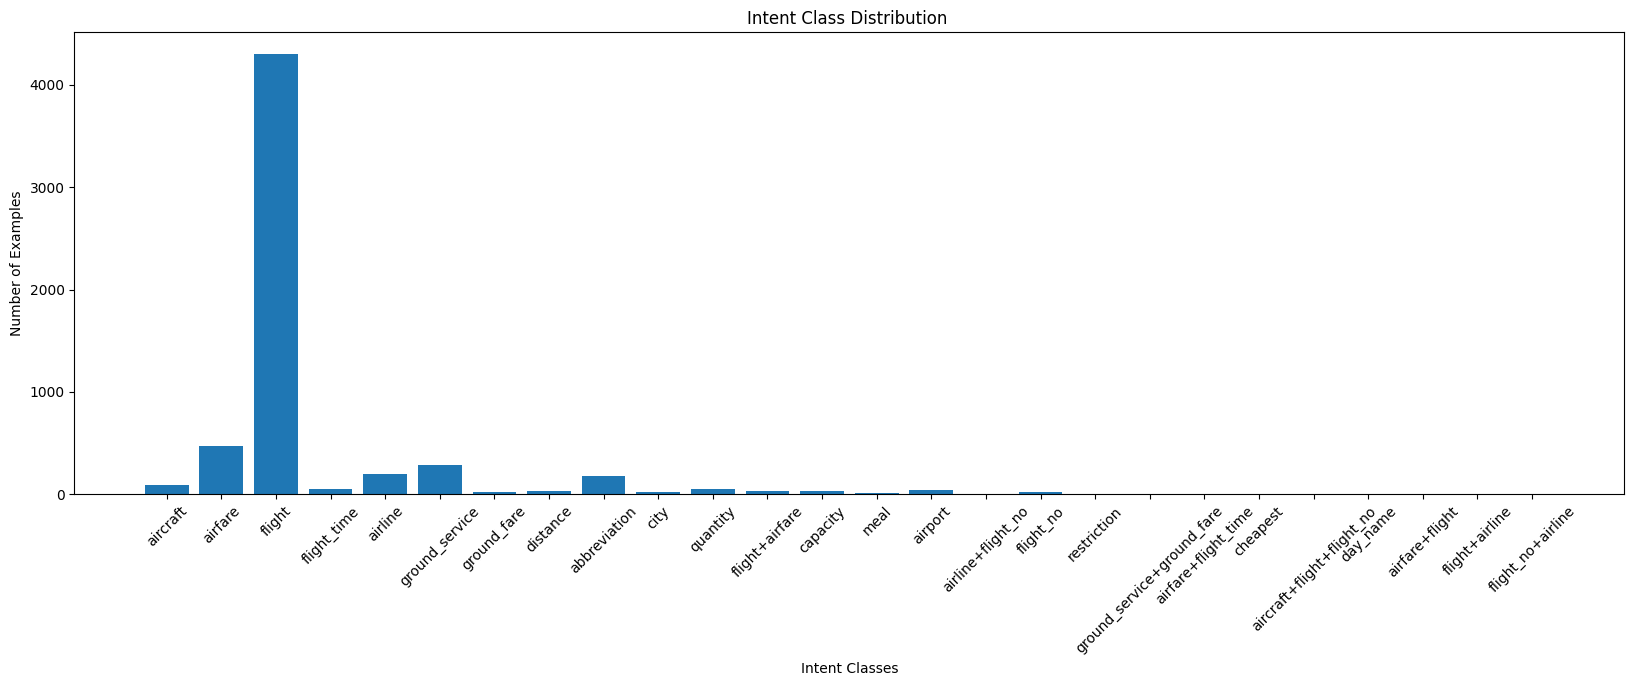

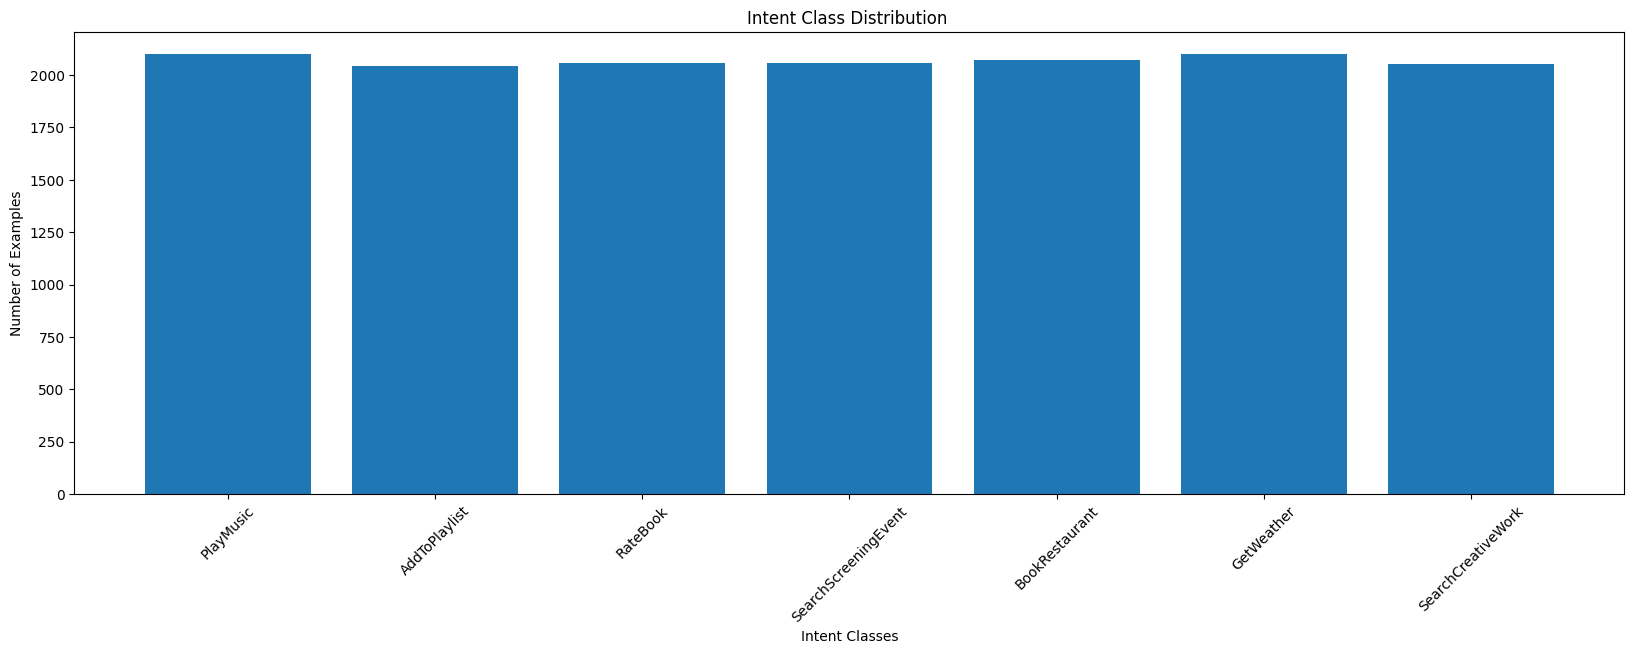

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

def plot_class_distribution(intent_labels):
    class_counts = Counter(intent_labels)
    intent_names = list(class_counts.keys())
    counts = list(class_counts.values())

    plt.figure(figsize=(20, 6))
    plt.bar(intent_names, counts)
    plt.xlabel("Intent Classes")
    plt.ylabel("Number of Examples")
    plt.title("Intent Class Distribution ")
    plt.xticks(rotation=45)
    plt.show()


plot_class_distribution(ATIS_intent_labels)
plot_class_distribution(SNIPS_intent_labels)


##Init weights

In [ ]:
def init_weights(mat):
    for m in mat.modules():
        if type(m) in [nn.GRU, nn.LSTM, nn.RNN]:
            for name, param in m.named_parameters():
                if 'weight_ih' in name:
                    for idx in range(4):
                        mul = param.shape[0]//4
                        torch.nn.init.xavier_uniform_(param[idx*mul:(idx+1)*mul])
                elif 'weight_hh' in name:
                    for idx in range(4):
                        mul = param.shape[0]//4
                        torch.nn.init.orthogonal_(param[idx*mul:(idx+1)*mul])
                elif 'bias' in name:
                    param.data.fill_(0)
        else:
            if type(m) in [nn.Linear]:
                torch.nn.init.uniform_(m.weight, -0.01, 0.01)
                if m.bias != None:
                    m.bias.data.fill_(0.01)

#Training set up

In [ ]:
hid_size = 256
emb_size = 512

lr = 0.00025 # learning rate
clip = 5 # gradient clipping

ATIS_out_slot = len(ATIS_lang.slot2id)
ATIS_out_int = len(ATIS_lang.intent2id)
ATIS_vocab_len = len(ATIS_lang.word2id)

SNIPS_out_slot = len(SNIPS_lang.slot2id)
SNIPS_out_int = len(SNIPS_lang.intent2id)
SNIPS_vocab_len = len(SNIPS_lang.word2id)

In [ ]:
#statistics
print("ATIS Slots: ", ATIS_out_slot - 1) #remove [PAD]
print("ATIS Intent: ", ATIS_out_int)
print("ATIS alt:", ATIS_vocab_len - 2) #remove [PAD] and [UNK]

print("\nSNIPS Slots: ", SNIPS_out_slot - 1) #remove [PAD]
print("SNIPS Intent: ", SNIPS_out_int)
print("SNIPS alt:", SNIPS_vocab_len - 2) #remove [PAD] and [UNK]

ATIS Slots:  129
ATIS Intent:  26
ATIS alt: 941

SNIPS Slots:  72
SNIPS Intent:  7
SNIPS alt: 12134


#Training and evaluation loop

In [ ]:
def training_loop(data, optimizer, criterion_slots, criterion_intents, model):
    model.train()
    loss_array = []
    for sample in data:
        optimizer.zero_grad() # Zeroing the gradient
        slots, intent = model(sample['utterances'], sample['slots_len'])
        loss_intent = criterion_intents(intent, sample['intents'])
        loss_slot = criterion_slots(slots, sample['y_slots'])
        loss = loss_intent + loss_slot # In joint training we sum the losses.
                                       # Is there another way to do that?
        loss_array.append(loss.item())
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step() # Update the weights
    return loss_array

In [ ]:
def eval_loop(data, criterion_slots, criterion_intents, model, lang):
    model.eval()
    loss_array = []

    ref_intents = []
    hyp_intents = []

    ref_slots = []
    hyp_slots = []

    results = 0

    with torch.no_grad(): # It used to avoid the creation of computational graph
        for sample in data:
            slots, intents = model(sample['utterances'], sample['slots_len'])
            loss_intent = criterion_intents(intents, sample['intents'])
            loss_slot = criterion_slots(slots, sample['y_slots'])
            loss = loss_intent + loss_slot
            loss_array.append(loss.item())
            # Intent inference
            # Get the highest probable class
            out_intents = [lang.id2intent[x]
                           for x in torch.argmax(intents, dim=1).tolist()]
            gt_intents = [lang.id2intent[x] for x in sample['intents'].tolist()]
            ref_intents.extend(gt_intents)
            hyp_intents.extend(out_intents)

            # Slot inference
            output_slots = torch.argmax(slots, dim=1)
            for id_seq, seq in enumerate(output_slots):
                length = sample['slots_len'].tolist()[id_seq]
                utt_ids = sample['utterance'][id_seq][:length].tolist()
                gt_ids = sample['y_slots'][id_seq].tolist()
                gt_slots = [lang.id2slot[elem] for elem in gt_ids[:length]]
                utterance = [lang.id2word[elem] for elem in utt_ids]
                to_decode = seq[:length].tolist()
                ref_slots.append([(utterance[id_el], elem) for id_el, elem in enumerate(gt_slots)])
                tmp_seq = []
                for id_el, elem in enumerate(to_decode):
                    tmp_seq.append((utterance[id_el], lang.id2slot[elem]))
                hyp_slots.append(tmp_seq)
    try:
        results = evaluate(ref_slots, hyp_slots)
    except Exception as ex:
        # Sometimes the model predics a class that is not in REF
        print(ex)
        ref_s = set([x[1] for x in ref_slots])
        hyp_s = set([x[1] for x in hyp_slots])
        print(hyp_s.difference(ref_s))

    report_intent = classification_report(ref_intents, hyp_intents,
                                          zero_division=False, output_dict=True)
    return results, report_intent, loss_array

In [ ]:
def Training (model, train_loader, valid_loader, test_loader, lang, criterion_slots, criterion_intents):
    n_epochs = 200
    patience = 10
    losses_train = []
    losses_dev = []
    sampled_epochs = []

    best_f1 = 0

    #for x in tqdm(range(1,n_epochs), leave = False):
    for x in range(1,n_epochs):
        loss = training_loop(train_loader, optimizer, criterion_slots,
                          criterion_intents, model)
        f1 = 0
        if x % 5 == 0:
            sampled_epochs.append(x)
            losses_train.append(np.asarray(loss).mean())
            results_dev, intent_res, loss_dev = eval_loop(valid_loader, criterion_slots,
                                                          criterion_intents, model, lang)
            losses_dev.append(np.asarray(loss_dev).mean())
            f1 = results_dev['total']['f']

            if f1 > best_f1:
                best_f1 = f1
            else:
                patience -= 1
            if patience <= 0: # Early stopping with patience
                break # Not nice but it keeps the code clean

    results_test, intent_test, _ = eval_loop(test_loader, criterion_slots,
                                            criterion_intents, model, lang)
    return (results_test, intent_test, losses_train, losses_dev, sampled_epochs)

# Training and evaluation loop with mask

In [ ]:
def new_training_loop_mask(data, optimizer, criterion_intents, model):
    model.train()
    loss_array = []
    for sample in data:
        optimizer.zero_grad()  # Zeroing the gradient
        slots, intent = model(sample['utterances'], sample['slots_len'])

        loss_intent = criterion_intents(intent, sample['intents'])
        crf_loss = -model.crf(slots, sample['y_slots'], mask=sample['mask'])
        loss = loss_intent + crf_loss

        loss_array.append(loss.item())

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()  # Update the weights

    return loss_array


In [ ]:
from sklearn.metrics import classification_report

def eval_loop_mask(data, model, lang, criterion_intents):
    model.eval()
    loss_array = []

    ref_intents = []
    hyp_intents = []

    ref_slots = []
    hyp_slots = []

    results = 0

    with torch.no_grad():
        for sample in data:
            slots, intent = model(sample['utterances'], sample['slots_len'])

            # CRF loss
            crf_loss = model.crf(slots, sample['y_slots'], mask=sample['mask'])

            loss_intent = criterion_intents(intent, sample['intents'])
            loss = crf_loss + loss_intent
            loss_array.append(loss.item())

            # Intent inference
            out_intents = [lang.id2intent[x] for x in torch.argmax(intent, dim=1).tolist()]
            gt_intents = [lang.id2intent[x] for x in sample['intents'].tolist()]
            ref_intents.extend(gt_intents)
            hyp_intents.extend(out_intents)

            # Slot inference
            decoded_slots = model.crf.decode(slots, mask=sample['mask'])
            for id_seq, seq in enumerate(decoded_slots):
                length = sample['slots_len'].tolist()[id_seq]
                utt_ids = sample['utterance'][id_seq][:length].tolist()
                gt_ids = sample['y_slots'][id_seq][:length].tolist()
                gt_slots = [lang.id2slot[elem] for elem in gt_ids]
                utterance = [lang.id2word[elem] for elem in utt_ids]
                to_decode = seq
                ref_slots.append([(utterance[id_el], elem) for id_el, elem in enumerate(gt_slots)])
                tmp_seq = []
                for id_el, elem in enumerate(to_decode):
                    tmp_seq.append((utterance[id_el], lang.id2slot[elem]))
                hyp_slots.append(tmp_seq)

    try:
        results = evaluate(ref_slots, hyp_slots)

    except Exception as ex:
        print(ex)
        ref_s = set([x[1] for x in ref_slots])
        hyp_s = set([x[1] for x in hyp_slots])
        print(hyp_s.difference(ref_s))

    report_intent = classification_report(ref_intents, hyp_intents,
                                          zero_division=False, output_dict=True)
    return results, report_intent, loss_array

In [ ]:
def Training_mask(model, optimizer, train_loader, valid_loader, test_loader, lang, criterion_intents):
    n_epochs = 200
    patience = 10
    losses_train = []
    losses_dev = []
    sampled_epochs = []

    best_f1 = 0

    for epoch in range(1, n_epochs):
        loss = new_training_loop_mask(train_loader, optimizer, criterion_intents, model)
        if epoch % 5 == 0:
            sampled_epochs.append(epoch)
            losses_train.append(np.asarray(loss).mean())
            results_dev, intent_res, loss_dev = eval_loop_mask(valid_loader, model, lang, criterion_intents)
            losses_dev.append(np.asarray(loss_dev).mean())

            f1 = results_dev['total']['f']

            if f1 > best_f1:
                best_f1 = f1
            else:
                patience -= 1
            if patience <= 0:
                break

    results_test, intent_test, _ = eval_loop_mask(test_loader, model, lang, criterion_intents)
    return results_test, intent_test, losses_train, losses_dev, sampled_epochs

#Baseline

## Baseline model

In [ ]:
class ModelIAS(nn.Module):

    def __init__(self, hid_size, out_slot, out_int, emb_size, vocab_len, n_layer=1, pad_index=0):
        super(ModelIAS, self).__init__()
        # hid_size = Hidden size
        # out_slot = number of slots (output size for slot filling)
        # out_int = number of intents (ouput size for intent class)
        # emb_size = word embedding size

        self.embedding = nn.Embedding(vocab_len, emb_size, padding_idx=pad_index)

        self.utt_encoder = nn.LSTM(emb_size, hid_size, n_layer, bidirectional=False)
        self.slot_out = nn.Linear(hid_size, out_slot)
        self.intent_out = nn.Linear(hid_size, out_int)
        self.dropout = nn.Dropout(0.1)

    def forward(self, utterance, seq_lengths):
        # utterance.size() = batch_size X seq_len
        utt_emb = self.embedding(utterance) # utt_emb.size() = batch_size X seq_len X emb_size
        #utt_emb = self.dropout(utt_emb)
        utt_emb = utt_emb.permute(1,0,2) # we need seq len first -> seq_len X batch_size X emb_size

        # pack_padded_sequence avoid computation over pad tokens reducing the computational cost

        packed_input = pack_padded_sequence(utt_emb, seq_lengths.cpu().numpy())
        # Process the batch
        packed_output, (last_hidden, cell) = self.utt_encoder(packed_input)
        # Unpack the sequence
        utt_encoded, input_sizes = pad_packed_sequence(packed_output)
        # Get the last hidden state
        last_hidden = last_hidden[-1,:,:]

        # Compute slot logits
        slots = self.slot_out(utt_encoded)
        #slots = self.dropout(slots)

        # Compute intent logits
        intent = self.intent_out(last_hidden)
        #intent = self.dropout(intent)

        # Slot size: seq_len, batch size, calsses
        slots = slots.permute(1,2,0) # We need this for computing the loss
        # Slot size: batch_size, classes, seq_len
        return slots, intent

In [ ]:
print('learning rate: ', lr, ' hidden size: ', hid_size, ' emb size: ', emb_size)
slot_f1s, intent_acc = [], []
runs = 5
for run in tqdm(range(0, runs)):

    ATIS_modelIAS = ModelIAS(hid_size, ATIS_out_slot, ATIS_out_int, emb_size, ATIS_vocab_len, pad_index=PAD_TOKEN).to(device)
    ATIS_modelIAS.apply(init_weights)

    optimizer = optim.Adam(ATIS_modelIAS.parameters(), lr=lr)
    criterion_slots = nn.CrossEntropyLoss(ignore_index=PAD_TOKEN)
    criterion_intents = nn.CrossEntropyLoss() # Because we do not have the pad token

    ATIS_IAS_results, ATIS_IAS_intent, losses_train, losses_dev, sampled_epochs = Training(ATIS_modelIAS, ATIS_train_loader, ATIS_valid_loader, ATIS_test_loader, ATIS_lang, criterion_slots, criterion_intents)

    print('\n run: ', run)
    print('Slot F1: ', ATIS_IAS_results['total']['f'])
    print('Intent Accuracy: ', ATIS_IAS_intent['accuracy'])

    intent_acc.append(ATIS_IAS_intent['accuracy'])
    slot_f1s.append(ATIS_IAS_results['total']['f'])

slot_f1s = np.asarray(slot_f1s)
intent_acc = np.asarray(intent_acc)

print('Slot F1', round(slot_f1s.mean(),3), '+-', round(slot_f1s.std(),3))
print('Intent Acc', round(intent_acc.mean(), 3), '+-', round(intent_acc.std(), 3))

learning rate:  0.00025  hidden size:  256  emb size:  512


 20%|██        | 1/5 [02:39<10:37, 159.42s/it]


 run:  0
Slot F1:  0.9326297273526826
Intent Accuracy:  0.9384098544232923


 40%|████      | 2/5 [05:06<07:36, 152.30s/it]


 run:  1
Slot F1:  0.9267521517653258
Intent Accuracy:  0.9451287793952967


 60%|██████    | 3/5 [08:06<05:29, 164.75s/it]


 run:  2
Slot F1:  0.9281068729126385
Intent Accuracy:  0.9440089585666294


 80%|████████  | 4/5 [10:28<02:35, 155.98s/it]


 run:  3
Slot F1:  0.9279802782179961
Intent Accuracy:  0.93505039193729


100%|██████████| 5/5 [13:38<00:00, 163.77s/it]


 run:  4
Slot F1:  0.9266748725162651
Intent Accuracy:  0.9462486002239642
Slot F1 0.928 +- 0.002
Intent Acc 0.942 +- 0.002


In [ ]:
#New train
print('learning rate: ', lr, ' hidden size: ', hid_size, ' emb size: ', emb_size)
slot_f1s, intent_acc = [], []
runs = 5
for run in tqdm(range(0, runs)):

    SNIPS_modelIAS = ModelIAS(hid_size, SNIPS_out_slot, SNIPS_out_int, emb_size, SNIPS_vocab_len, pad_index=PAD_TOKEN).to(device)
    SNIPS_modelIAS.apply(init_weights)

    optimizer = optim.Adam(SNIPS_modelIAS.parameters(), lr=lr)
    criterion_slots = nn.CrossEntropyLoss(ignore_index=PAD_TOKEN)
    criterion_intents = nn.CrossEntropyLoss() # Because we do not have the pad token

    SNIPS_IAS_results, SNIPS_IAS_intent, losses_train, losses_dev, sampled_epochs = Training(SNIPS_modelIAS, SNIPS_train_loader, SNIPS_valid_loader, SNIPS_test_loader, SNIPS_lang, criterion_slots, criterion_intents)

    print('\n run: ', run)
    print('Slot F1: ', SNIPS_IAS_results['total']['f'])
    print('Intent Accuracy: ', SNIPS_IAS_intent['accuracy'])

    intent_acc.append(SNIPS_IAS_intent['accuracy'])
    slot_f1s.append(SNIPS_IAS_results['total']['f'])

slot_f1s = np.asarray(slot_f1s)
intent_acc = np.asarray(intent_acc)

print('Slot F1', round(slot_f1s.mean(),3), '+-', round(slot_f1s.std(),3))
print('Intent Acc', round(intent_acc.mean(), 3), '+-', round(intent_acc.std(), 3))

learning rate:  0.00025  hidden size:  256  emb size:  512


 20%|██        | 1/5 [04:40<18:41, 280.29s/it]


 run:  0
Slot F1:  0.821880894637564
Intent Accuracy:  0.96


 40%|████      | 2/5 [09:12<13:47, 275.67s/it]


 run:  1
Slot F1:  0.8206096574049097
Intent Accuracy:  0.9657142857142857


 60%|██████    | 3/5 [13:32<08:56, 268.28s/it]


 run:  2
Slot F1:  0.8166442953020134
Intent Accuracy:  0.9657142857142857


 80%|████████  | 4/5 [18:15<04:34, 274.14s/it]


 run:  3
Slot F1:  0.8194519075765717
Intent Accuracy:  0.9671428571428572


100%|██████████| 5/5 [22:16<00:00, 267.26s/it]


 run:  4
Slot F1:  0.8164471916151572
Intent Accuracy:  0.9728571428571429
Slot F1 0.819 +- 0.002
Intent Acc 0.966 +- 0.004


#BiLSTM

In [ ]:
class BiLSTM_Model(nn.Module):
    def __init__(self, hidden_size, slot_output_size, intent_output_size, emb_size, vocab_size, n_layer=1, pad_index=0):
        super(BiLSTM_Model, self).__init__()

        self.embedding = nn.Embedding(vocab_size, emb_size, padding_idx=pad_index)
        self.utt_encoder = nn.LSTM(emb_size, hid_size, n_layer, bidirectional=True)  # Bidirectional LSTM
        self.slot_out = nn.Linear(hidden_size * 2, slot_output_size)
        self.intent_out = nn.Linear(hidden_size * 2, intent_output_size)
        self.dropout = nn.Dropout(0.1)

    def forward(self, utterance, seq_lengths):
        utt_emb = self.embedding(utterance) # utt_emb.size() = batch_size X seq_len X emb_size
        utt_emb = self.dropout(utt_emb)
        utt_emb = utt_emb.permute(1,0,2) # we need seq len first -> seq_len X batch_size X emb_size

        # pack_padded_sequence avoid computation over pad tokens reducing the computational cost
        packed_input = pack_padded_sequence(utt_emb, seq_lengths.cpu().numpy())
        # Process the batch
        packed_output, (last_hidden,_) = self.utt_encoder(packed_input)
        # Unpack the sequence
        utt_encoded, input_sizes = pad_packed_sequence(packed_output)

        # Get the last hidden state
        #last_hidden = last_hidden[-1,:,:]
        last_hidden = torch.cat((last_hidden[-2,:,:], last_hidden[-1,:,:]), dim=1)

        # Compute slot logits
        slots = self.slot_out(utt_encoded)
        slots = self.dropout(slots)
        # Compute intent logits
        intent = self.intent_out(last_hidden)
        intent = self.dropout(intent)

        # Slot size: seq_len, batch size, calsses
        slots = slots.permute(1,2,0) # We need this for computing the loss
        # Slot size: batch_size, classes, seq_len

        return slots, intent


In [ ]:
#new run
print('learning rate: ', lr, ' hidden size: ', hid_size, ' emb size: ', emb_size)
slot_f1s, intent_acc = [], []
runs = 5
for run in tqdm(range(0, runs)):

    ATIS_BiLSTM_Model = BiLSTM_Model(hid_size, ATIS_out_slot, ATIS_out_int, emb_size, ATIS_vocab_len, pad_index=PAD_TOKEN).to(device)

    ATIS_BiLSTM_Model.apply(init_weights)

    optimizer = optim.Adam(ATIS_BiLSTM_Model.parameters(), lr=lr)
    criterion_slots = nn.CrossEntropyLoss(ignore_index=PAD_TOKEN)
    criterion_intents = nn.CrossEntropyLoss() # Because we do not have the pad token

    ATIS_BiLSTM_results, ATIS_BiLSTM_intent, losses_train, losses_dev, sampled_epochs = Training(ATIS_BiLSTM_Model, ATIS_train_loader, ATIS_valid_loader, ATIS_test_loader, ATIS_lang, criterion_slots, criterion_intents)

    print('\n run: ', run)
    print('Slot F1: ', ATIS_BiLSTM_results['total']['f'])
    print('Intent Accuracy: ', ATIS_BiLSTM_intent['accuracy'])

    intent_acc.append(ATIS_BiLSTM_intent['accuracy'])
    slot_f1s.append(ATIS_BiLSTM_results['total']['f'])

slot_f1s = np.asarray(slot_f1s)
intent_acc = np.asarray(intent_acc)

print('Slot F1', round(slot_f1s.mean(),3), '+-', round(slot_f1s.std(),3))
print('Intent Acc', round(intent_acc.mean(), 3), '+-', round(intent_acc.std(), 3))

learning rate:  0.00025  hidden size:  256  emb size:  512


 20%|██        | 1/5 [03:27<13:48, 207.21s/it]


 run:  0
Slot F1:  0.9469964664310954
Intent Accuracy:  0.9518477043673013


 40%|████      | 2/5 [05:44<08:18, 166.01s/it]


 run:  1
Slot F1:  0.9450432938681746
Intent Accuracy:  0.9563269876819709


 60%|██████    | 3/5 [08:28<05:30, 165.14s/it]


 run:  2
Slot F1:  0.9430234609278533
Intent Accuracy:  0.9540873460246361


 80%|████████  | 4/5 [11:17<02:46, 166.79s/it]


 run:  3
Slot F1:  0.9435626102292769
Intent Accuracy:  0.9563269876819709


100%|██████████| 5/5 [14:12<00:00, 170.57s/it]


 run:  4
Slot F1:  0.9453069865913902
Intent Accuracy:  0.9552071668533034
Slot F1 0.945 +- 0.001
Intent Acc 0.955 +- 0.002


In [ ]:
#new run
print('learning rate: ', lr, ' hidden size: ', hid_size, ' emb size: ', emb_size)
slot_f1s, intent_acc = [], []
runs = 5
for run in tqdm(range(0, runs)):

    SNIPS_BiLSTM_Model = BiLSTM_Model(hid_size, SNIPS_out_slot, SNIPS_out_int, emb_size, SNIPS_vocab_len, pad_index=PAD_TOKEN).to(device)

    SNIPS_BiLSTM_Model.apply(init_weights)

    optimizer = optim.Adam(SNIPS_BiLSTM_Model.parameters(), lr=lr)
    criterion_slots = nn.CrossEntropyLoss(ignore_index=PAD_TOKEN)
    criterion_intents = nn.CrossEntropyLoss() # Because we do not have the pad token

    SNIPS_BiLSTM_results, SNIPS_BiLSTM_intent, losses_train, losses_dev, sampled_epochs = Training(SNIPS_BiLSTM_Model, SNIPS_train_loader, SNIPS_valid_loader, SNIPS_test_loader, SNIPS_lang, criterion_slots, criterion_intents)

    print('\n run: ', run)
    print('Slot F1: ', SNIPS_BiLSTM_results['total']['f'])
    print('Intent Accuracy: ', SNIPS_BiLSTM_intent['accuracy'])

    intent_acc.append(SNIPS_BiLSTM_intent['accuracy'])
    slot_f1s.append(SNIPS_BiLSTM_results['total']['f'])

slot_f1s = np.asarray(slot_f1s)
intent_acc = np.asarray(intent_acc)

print('Slot F1', round(slot_f1s.mean(),3), '+-', round(slot_f1s.std(),3))
print('Intent Acc', round(intent_acc.mean(), 3), '+-', round(intent_acc.std(), 3))

learning rate:  0.00025  hidden size:  256  emb size:  512


 20%|██        | 1/5 [05:04<20:18, 304.54s/it]


 run:  0
Slot F1:  0.8884050081654872
Intent Accuracy:  0.9728571428571429


 40%|████      | 2/5 [10:09<15:15, 305.01s/it]


 run:  1
Slot F1:  0.8911973756150902
Intent Accuracy:  0.9785714285714285


 60%|██████    | 3/5 [15:53<10:45, 322.56s/it]


 run:  2
Slot F1:  0.898876404494382
Intent Accuracy:  0.9728571428571429


 80%|████████  | 4/5 [21:37<05:30, 330.92s/it]


 run:  3
Slot F1:  0.8941755537325677
Intent Accuracy:  0.9671428571428572


100%|██████████| 5/5 [27:04<00:00, 324.92s/it]


 run:  4
Slot F1:  0.8908941755537325
Intent Accuracy:  0.9714285714285714
Slot F1 0.893 +- 0.004
Intent Acc 0.973 +- 0.004


#BiGRU

In [ ]:
class GRU_Model(nn.Module):
    def __init__(self, hid_size, out_slot, out_int, emb_size, vocab_len, n_layer=2, pad_index=0):
        super(GRU_Model, self).__init__()

        self.embedding = nn.Embedding(vocab_len, emb_size, padding_idx=pad_index)
        self.utt_encoder = nn.GRU(emb_size, hid_size, n_layer, bidirectional=True)
        self.slot_out = nn.Linear(hid_size * 2, out_slot)
        self.intent_out = nn.Linear(hid_size * 2, out_int)
        self.dropout = nn.Dropout(0.1)

    def forward(self, utterance, seq_lengths):
        utt_emb = self.embedding(utterance)
        utt_emb = self.dropout(utt_emb)
        utt_emb = utt_emb.permute(1,0,2)

        utt_encoded, last_hidden = self.utt_encoder(utt_emb)

        last_hidden = torch.cat((last_hidden[-2,:,:], last_hidden[-1,:,:]), dim=1)
        #last_hidden = last_hidden[-1,:,:]

        slots = self.slot_out(utt_encoded)
        slots = self.dropout(slots)

        intent = self.intent_out(last_hidden)
        intent = self.dropout(intent)

        slots = slots.permute(1,2,0)

        return slots, intent

In [ ]:
#new run
print('learning rate: ', lr, ' hidden size: ', hid_size, ' emb size: ', emb_size)
slot_f1s, intent_acc = [], []
runs = 5
for run in tqdm(range(0, runs)):

    ATIS_GRU_Model = GRU_Model(hid_size, ATIS_out_slot, ATIS_out_int, emb_size, ATIS_vocab_len, pad_index=PAD_TOKEN).to(device)

    ATIS_GRU_Model.apply(init_weights)

    optimizer = optim.Adam(ATIS_GRU_Model.parameters(), lr=lr)
    criterion_slots = nn.CrossEntropyLoss(ignore_index=PAD_TOKEN)
    criterion_intents = nn.CrossEntropyLoss() # Because we do not have the pad token

    ATIS_GRU_results, ATIS_GRU_intent, losses_train, losses_dev, sampled_epochs = Training(ATIS_GRU_Model, ATIS_train_loader,
                                                                                           ATIS_valid_loader, ATIS_test_loader, ATIS_lang,
                                                                                           criterion_slots, criterion_intents)

    print('\n run: ', run)
    print('Slot F1: ', ATIS_GRU_results['total']['f'])
    print('Intent Accuracy: ', ATIS_GRU_intent['accuracy'])

    intent_acc.append(ATIS_GRU_intent['accuracy'])
    slot_f1s.append(ATIS_GRU_results['total']['f'])

slot_f1s = np.asarray(slot_f1s)
intent_acc = np.asarray(intent_acc)

print('Slot F1', round(slot_f1s.mean(),3), '+-', round(slot_f1s.std(),3))
print('Intent Acc', round(intent_acc.mean(), 3), '+-', round(intent_acc.std(), 3))

learning rate:  0.00025  hidden size:  256  emb size:  512


 20%|██        | 1/5 [02:31<10:07, 152.00s/it]


 run:  0
Slot F1:  0.9486180014174344
Intent Accuracy:  0.9608062709966405


 40%|████      | 2/5 [05:11<07:48, 156.15s/it]


 run:  1
Slot F1:  0.9488947833775419
Intent Accuracy:  0.9664053751399776


 60%|██████    | 3/5 [07:49<05:14, 157.30s/it]


 run:  2
Slot F1:  0.9509474057021428
Intent Accuracy:  0.9574468085106383


 80%|████████  | 4/5 [10:08<02:29, 149.88s/it]


 run:  3
Slot F1:  0.9470702779252965
Intent Accuracy:  0.9563269876819709


100%|██████████| 5/5 [12:33<00:00, 150.63s/it]


 run:  4
Slot F1:  0.9495234733498059
Intent Accuracy:  0.9552071668533034
Slot F1 0.949 +- 0.001
Intent Acc 0.959 +- 0.004


In [ ]:
#new run
print('learning rate: ', lr, ' hidden size: ', hid_size, ' emb size: ', emb_size)
slot_f1s, intent_acc = [], []
runs = 5
for run in tqdm(range(0, runs)):

    SNIPS_GRU_Model = GRU_Model(hid_size, SNIPS_out_slot, SNIPS_out_int, emb_size, SNIPS_vocab_len, pad_index=PAD_TOKEN).to(device)

    SNIPS_GRU_Model.apply(init_weights)

    optimizer = optim.Adam(SNIPS_GRU_Model.parameters(), lr=lr)
    criterion_slots = nn.CrossEntropyLoss(ignore_index=PAD_TOKEN)
    criterion_intents = nn.CrossEntropyLoss() # Because we do not have the pad token

    SNIPS_GRU_results, SNIPS_GRU_intent, losses_train, losses_dev, sampled_epochs = Training(SNIPS_GRU_Model, SNIPS_train_loader,
                                                                                             SNIPS_valid_loader, SNIPS_test_loader, SNIPS_lang,
                                                                                             criterion_slots, criterion_intents)

    print('\n run: ', run)
    print('Slot F1: ', SNIPS_GRU_results['total']['f'])
    print('Intent Accuracy: ', SNIPS_GRU_intent['accuracy'])

    intent_acc.append(SNIPS_GRU_intent['accuracy'])
    slot_f1s.append(SNIPS_GRU_results['total']['f'])

slot_f1s = np.asarray(slot_f1s)
intent_acc = np.asarray(intent_acc)

print('Slot F1', round(slot_f1s.mean(),3), '+-', round(slot_f1s.std(),3))
print('Intent Acc', round(intent_acc.mean(), 3), '+-', round(intent_acc.std(), 3))

learning rate:  0.00025  hidden size:  256  emb size:  512


 20%|██        | 1/5 [05:47<23:09, 347.26s/it]


 run:  0
Slot F1:  0.9049972542559034
Intent Accuracy:  0.98


 40%|████      | 2/5 [10:47<15:59, 319.87s/it]


 run:  1
Slot F1:  0.9066447007138935
Intent Accuracy:  0.9728571428571429


 60%|██████    | 3/5 [17:15<11:41, 350.80s/it]


 run:  2
Slot F1:  0.8954895489548955
Intent Accuracy:  0.97


 80%|████████  | 4/5 [22:42<05:41, 341.38s/it]


 run:  3
Slot F1:  0.9054945054945055
Intent Accuracy:  0.9728571428571429


100%|██████████| 5/5 [28:19<00:00, 339.81s/it]


 run:  4
Slot F1:  0.9012379642365888
Intent Accuracy:  0.9757142857142858
Slot F1 0.903 +- 0.004
Intent Acc 0.974 +- 0.003


#CRF

##Bi-LSTM with CRF

In [ ]:
from torchcrf import CRF

class BiLSTM_CRF_Model(nn.Module):
    def __init__(self, hid_size, out_slot, out_int, emb_size, vocab_len, n_layer=2, pad_index=0):
        super(BiLSTM_CRF_Model, self).__init__()

        self.embedding = nn.Embedding(vocab_len, emb_size, padding_idx=pad_index)
        self.utt_encoder = nn.LSTM(emb_size, hid_size, n_layer, bidirectional=True, batch_first=True)
        self.slot_out = nn.Linear(hid_size*2, out_slot)
        self.intent_out = nn.Linear(hid_size*2, out_int)
        self.dropout = nn.Dropout(0.1)
        self.crf = CRF(out_slot, batch_first=True)

    def forward(self, utterance, seq_lengths):
        #utt_emb = self.dropout(self.embedding(utterance))
        utt_emb = self.embedding(utterance)

        packed_input = pack_padded_sequence(utt_emb, seq_lengths.cpu().numpy(), batch_first=True)
        packed_output, (last_hidden, cell) = self.utt_encoder(packed_input)
        utt_encoded, _ = pad_packed_sequence(packed_output, batch_first=True)

        last_hidden = torch.cat((last_hidden[-2,:,:], last_hidden[-1,:,:]), dim=1)

        slots = self.slot_out(utt_encoded)
        slots = self.dropout(slots)
        intent = self.intent_out(last_hidden)
        intent = self.dropout(intent)

        return slots, intent


In [ ]:
#new run
print('learning rate: ', lr, ' hidden size: ', hid_size, ' emb size: ', emb_size)
slot_f1s, intent_acc = [], []
runs = 5
for run in tqdm(range(0, runs)):

    ATIS_BiLSTM_CRF_model = BiLSTM_CRF_Model(hid_size, ATIS_out_slot, ATIS_out_int, emb_size, ATIS_vocab_len, pad_index=PAD_TOKEN).to(device)
    ATIS_BiLSTM_CRF_model.apply(init_weights)

    optimizer = optim.Adam(ATIS_BiLSTM_CRF_model.parameters(), lr=lr)
    #criterion_slots = nn.CrossEntropyLoss(ignore_index=PAD_TOKEN)
    criterion_intents = nn.CrossEntropyLoss()

    ATIS_BiLSTM_CRF_results, ATIS_BiLSTM_CRF_intent, losses_train, losses_dev, sampled_epochs = Training_mask(ATIS_BiLSTM_CRF_model, optimizer,
                                                                                                              ATIS_train_loader, ATIS_valid_loader,
                                                                                                              ATIS_test_loader, ATIS_lang, criterion_intents)

    print('\n run: ', run)
    print('Slot F1: ', ATIS_BiLSTM_CRF_results['total']['f'])
    print('Intent Accuracy: ', ATIS_BiLSTM_CRF_intent['accuracy'])

    intent_acc.append(ATIS_BiLSTM_CRF_intent['accuracy'])
    slot_f1s.append(ATIS_BiLSTM_CRF_results['total']['f'])

slot_f1s = np.asarray(slot_f1s)
intent_acc = np.asarray(intent_acc)

print('Slot F1', round(slot_f1s.mean(),3), '+-', round(slot_f1s.std(),3))
print('Intent Acc', round(intent_acc.mean(), 3), '+-', round(intent_acc.std(), 3))

learning rate:  0.00025  hidden size:  256  emb size:  512


 20%|██        | 1/5 [06:35<26:22, 395.59s/it]


 run:  0
Slot F1:  0.9512367491166077
Intent Accuracy:  0.910414333706607


 40%|████      | 2/5 [12:55<19:18, 386.30s/it]


 run:  1
Slot F1:  0.9498764560536535
Intent Accuracy:  0.9238521836506159


 60%|██████    | 3/5 [19:27<12:57, 388.81s/it]


 run:  2
Slot F1:  0.9510464703795672
Intent Accuracy:  0.9316909294512878


 80%|████████  | 4/5 [26:00<06:30, 390.51s/it]


 run:  3
Slot F1:  0.9496021220159151
Intent Accuracy:  0.9305711086226204


100%|██████████| 5/5 [32:16<00:00, 387.28s/it]


 run:  4
Slot F1:  0.9487315948199397
Intent Accuracy:  0.9227323628219485
Slot F1 0.95 +- 0.001
Intent Acc 0.924 +- 0.008


In [ ]:
#new run
print('learning rate: ', lr, ' hidden size: ', hid_size, ' emb size: ', emb_size)
slot_f1s, intent_acc = [], []
runs = 5
for run in tqdm(range(0, runs)):

    SNIPS_BiLSTM_CRF_model = BiLSTM_CRF_Model(hid_size, SNIPS_out_slot, SNIPS_out_int, emb_size, SNIPS_vocab_len, pad_index=PAD_TOKEN).to(device)
    SNIPS_BiLSTM_CRF_model.apply(init_weights)

    optimizer = optim.Adam(SNIPS_BiLSTM_CRF_model.parameters(), lr=lr)
    #criterion_slots = nn.CrossEntropyLoss(ignore_index=PAD_TOKEN)
    criterion_intents = nn.CrossEntropyLoss()

    SNIPS_BiLSTM_CRF_results, SNIPS_BiLSTM_CRF_intent, losses_train, losses_dev, sampled_epochs = Training_mask(SNIPS_BiLSTM_CRF_model, optimizer,
                                                                                                              SNIPS_train_loader, SNIPS_valid_loader,
                                                                                                              SNIPS_test_loader, SNIPS_lang, criterion_intents)

    print('\n run: ', run)
    print('Slot F1: ', SNIPS_BiLSTM_CRF_results['total']['f'])
    print('Intent Accuracy: ', SNIPS_BiLSTM_CRF_intent['accuracy'])

    intent_acc.append(SNIPS_BiLSTM_CRF_intent['accuracy'])
    slot_f1s.append(SNIPS_BiLSTM_CRF_results['total']['f'])

slot_f1s = np.asarray(slot_f1s)
intent_acc = np.asarray(intent_acc)

print('Slot F1', round(slot_f1s.mean(),3), '+-', round(slot_f1s.std(),3))
print('Intent Acc', round(intent_acc.mean(), 3), '+-', round(intent_acc.std(), 3))

learning rate:  0.00025  hidden size:  256  emb size:  512


 20%|██        | 1/5 [13:55<55:43, 835.83s/it]


 run:  0
Slot F1:  0.9148877183254783
Intent Accuracy:  0.9685714285714285


 40%|████      | 2/5 [27:10<40:34, 811.58s/it]


 run:  1
Slot F1:  0.900831024930748
Intent Accuracy:  0.9685714285714285


 60%|██████    | 3/5 [41:59<28:13, 846.82s/it]


 run:  2
Slot F1:  0.9102457884562276
Intent Accuracy:  0.9671428571428572


 80%|████████  | 4/5 [55:45<13:58, 838.72s/it]


 run:  3
Slot F1:  0.9089903181189488
Intent Accuracy:  0.9685714285714285


100%|██████████| 5/5 [1:08:28<00:00, 821.78s/it]


 run:  4
Slot F1:  0.9159966731355698
Intent Accuracy:  0.9657142857142857
Slot F1 0.91 +- 0.005
Intent Acc 0.968 +- 0.001


##BiGRU with CRF

In [ ]:
from torchcrf import CRF

class GRU_CRF_Model(nn.Module):
    def __init__(self, hid_size, out_slot, out_int, emb_size, vocab_len, n_layer=2, pad_index=0):
        super(GRU_CRF_Model, self).__init__()

        self.embedding = nn.Embedding(vocab_len, emb_size, padding_idx=pad_index)
        self.utt_encoder = nn.GRU(emb_size, hid_size, n_layer, bidirectional=True)
        self.slot_out = nn.Linear(hid_size *2, out_slot)
        self.intent_out = nn.Linear(hid_size *2, out_int)
        self.dropout = nn.Dropout(0.1)
        self.crf = CRF(out_slot, batch_first=True)

    def forward(self, utterance, seq_lengths):
        utt_emb = self.dropout(self.embedding(utterance))

        packed_input = pack_padded_sequence(utt_emb, seq_lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_output, last_hidden = self.utt_encoder(packed_input)
        utt_encoded, _ = pad_packed_sequence(packed_output, batch_first=True)

        last_hidden = torch.cat((last_hidden[-2,:,:], last_hidden[-1,:,:]), dim=1)

        slots = self.slot_out(utt_encoded)
        intent = self.intent_out(last_hidden)

        return slots, intent


In [ ]:
#new run
print('learning rate: ', lr, ' hidden size: ', hid_size, ' emb size: ', emb_size)
slot_f1s, intent_acc = [], []
runs = 5
for run in tqdm(range(0, runs)):

    ATIS_GRU_CRF_model = GRU_CRF_Model(hid_size, ATIS_out_slot, ATIS_out_int, emb_size, ATIS_vocab_len, pad_index=PAD_TOKEN).to(device)
    ATIS_GRU_CRF_model.apply(init_weights)

    optimizer = optim.Adam(ATIS_GRU_CRF_model.parameters(), lr=lr)
    #criterion_slots = nn.CrossEntropyLoss(ignore_index=PAD_TOKEN)
    criterion_intents = nn.CrossEntropyLoss()

    ATIS_GRU_CRF_results, ATIS_GRU_CRF_intent, losses_train, losses_dev, sampled_epochs = Training_mask(ATIS_GRU_CRF_model, optimizer,
                                                                                                              ATIS_train_loader, ATIS_valid_loader,
                                                                                                              ATIS_test_loader, ATIS_lang, criterion_intents)

    print('\n run: ', run)
    print('Slot F1: ', ATIS_GRU_CRF_results['total']['f'])
    print('Intent Accuracy: ', ATIS_GRU_CRF_intent['accuracy'])

    intent_acc.append(ATIS_GRU_CRF_intent['accuracy'])
    slot_f1s.append(ATIS_GRU_CRF_results['total']['f'])

slot_f1s = np.asarray(slot_f1s)
intent_acc = np.asarray(intent_acc)

print('Slot F1', round(slot_f1s.mean(),3), '+-', round(slot_f1s.std(),3))
print('Intent Acc', round(intent_acc.mean(), 3), '+-', round(intent_acc.std(), 3))

learning rate:  0.00025  hidden size:  256  emb size:  512


 20%|██        | 1/5 [07:04<28:18, 424.56s/it]


 run:  0
Slot F1:  0.9508196721311475
Intent Accuracy:  0.9305711086226204


 40%|████      | 2/5 [14:38<22:05, 441.82s/it]


 run:  1
Slot F1:  0.9504845814977974
Intent Accuracy:  0.9328107502799552


 60%|██████    | 3/5 [22:01<14:45, 442.55s/it]


 run:  2
Slot F1:  0.9554770318021201
Intent Accuracy:  0.9440089585666294


 80%|████████  | 4/5 [29:05<07:14, 434.98s/it]


 run:  3
Slot F1:  0.9519434628975265
Intent Accuracy:  0.9384098544232923


100%|██████████| 5/5 [35:41<00:00, 428.29s/it]


 run:  4
Slot F1:  0.9511032656663725
Intent Accuracy:  0.9372900335946248
Slot F1 0.952 +- 0.002
Intent Acc 0.937 +- 0.005


In [ ]:
#new run
print('learning rate: ', lr, ' hidden size: ', hid_size, ' emb size: ', emb_size)
slot_f1s, intent_acc = [], []
runs = 5
for run in tqdm(range(0, runs)):

    SNIPS_GRU_CRF_model = GRU_CRF_Model(hid_size, SNIPS_out_slot, SNIPS_out_int, emb_size, SNIPS_vocab_len, pad_index=PAD_TOKEN).to(device)
    SNIPS_GRU_CRF_model.apply(init_weights)

    optimizer = optim.Adam(SNIPS_GRU_CRF_model.parameters(), lr=lr)
    #criterion_slots = nn.CrossEntropyLoss(ignore_index=PAD_TOKEN)
    criterion_intents = nn.CrossEntropyLoss()

    SNIPS_GRU_CRF_results, SNIPS_GRU_CRF_intent, losses_train, losses_dev, sampled_epochs = Training_mask(SNIPS_GRU_CRF_model, optimizer,
                                                                                                              SNIPS_train_loader, SNIPS_valid_loader,
                                                                                                              SNIPS_test_loader, SNIPS_lang, criterion_intents)

    print('\n run: ', run)
    print('Slot F1: ', SNIPS_GRU_CRF_results['total']['f'])
    print('Intent Accuracy: ', SNIPS_GRU_CRF_intent['accuracy'])

    intent_acc.append(SNIPS_GRU_CRF_intent['accuracy'])
    slot_f1s.append(SNIPS_GRU_CRF_results['total']['f'])

slot_f1s = np.asarray(slot_f1s)
intent_acc = np.asarray(intent_acc)

print('Slot F1', round(slot_f1s.mean(),3), '+-', round(slot_f1s.std(),3))
print('Intent Acc', round(intent_acc.mean(), 3), '+-', round(intent_acc.std(), 3))

learning rate:  0.00025  hidden size:  256  emb size:  512


 20%|██        | 1/5 [13:49<55:18, 829.65s/it]


 run:  0
Slot F1:  0.9103448275862068
Intent Accuracy:  0.9714285714285714


 40%|████      | 2/5 [28:13<42:29, 849.73s/it]


 run:  1
Slot F1:  0.9122516556291392
Intent Accuracy:  0.9657142857142857


 60%|██████    | 3/5 [44:16<30:02, 901.48s/it]


 run:  2
Slot F1:  0.9155826183227236
Intent Accuracy:  0.9728571428571429


 80%|████████  | 4/5 [57:09<14:10, 850.90s/it]


 run:  3
Slot F1:  0.9174515235457064
Intent Accuracy:  0.9671428571428572


100%|██████████| 5/5 [1:09:15<00:00, 831.06s/it]


 run:  4
Slot F1:  0.9204419889502762
Intent Accuracy:  0.9757142857142858
Slot F1 0.915 +- 0.004
Intent Acc 0.971 +- 0.004


#Focal loss and label smoothing

##model with LSTM

In [ ]:
#alpha: 0.2  gamma:  1  epsilon:  0.1
class BiLSTM_Focal_LabelSmoothing_Model(nn.Module):
    def __init__(self, hid_size, out_slot, out_int, emb_size, vocab_len, n_layer=2,
                 pad_index=0, alpha=0.2, gamma=1, epsilon=0.1):
        super(BiLSTM_Focal_LabelSmoothing_Model, self).__init__()

        self.embedding = nn.Embedding(vocab_len, emb_size, padding_idx=pad_index)
        self.utt_encoder = nn.LSTM(emb_size, hid_size, n_layer, bidirectional=True)
        self.slot_out = nn.Linear(hid_size * 2, out_slot)
        self.intent_out = nn.Linear(hid_size * 2, out_int)
        self.dropout = nn.Dropout(0.1)
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon

    def forward(self, utterance, seq_lengths):
        utt_emb = self.dropout(self.embedding(utterance))

        packed_input = pack_padded_sequence(utt_emb, seq_lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_output, (last_hidden, cell) = self.utt_encoder(packed_input)
        utt_encoded, input_sizes = pad_packed_sequence(packed_output, batch_first=True)
        #utt_encoded = self.dropout(utt_encoded)

        last_hidden = torch.cat((last_hidden[-2,:,:], last_hidden[-1,:,:]), dim=1)

        slots = self.slot_out(utt_encoded)
        slots = self.dropout(slots)
        intent = self.intent_out(last_hidden)
        intent = self.dropout(intent)

        slots = slots.permute(0,2,1)

        return slots, intent

    def intent_loss_func(self, intent, intent_labels):
        crit = nn.CrossEntropyLoss(reduction="none")
        ce_loss = crit(intent, intent_labels)
        pt = torch.exp(-ce_loss) #prob of true class
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        smoothed_labels = self.smooth_labels_func(intent_labels, num_classes=intent.size(1), epsilon=self.epsilon)
        smoothed_loss = -torch.sum(smoothed_labels * F.log_softmax(intent, dim=-1), dim=-1)
        return (focal_loss + smoothed_loss).mean()

    def smooth_labels_func(self, targets, num_classes, epsilon):
        one_hot = torch.zeros(targets.size(0), num_classes).to(targets.device)
        one_hot.scatter_(1, targets.view(-1, 1), 1 - epsilon)
        smoothed_labels = one_hot + epsilon / num_classes
        return smoothed_labels

In [ ]:
from itertools import product

# hyperparameter grid
alpha_values = [0.2, 0.5, 0.8]
gamma_values = [1, 2, 3]
epsilon_values = [0.05, 0.1, 0.2]

# Iterate through combinations
for alpha, gamma, epsilon in product(alpha_values, gamma_values, epsilon_values):
    ATIS_BiLSTM_FocLabSmo_model = BiLSTM_Focal_LabelSmoothing_Model(hid_size, ATIS_out_slot, ATIS_out_int,
                                                                    emb_size, ATIS_vocab_len, n_layer=2, pad_index=PAD_TOKEN,
                                                                    alpha=alpha, gamma=gamma, epsilon=epsilon).to(device)

    ATIS_BiLSTM_FocLabSmo_model.apply(init_weights)

    optimizer = optim.Adam(ATIS_BiLSTM_FocLabSmo_model.parameters(), lr=0.00025)
    criterion_slots = nn.CrossEntropyLoss(ignore_index=PAD_TOKEN)

    ATIS_BiLSTM_FocLabSmo_results, ATIS_BiLSTM_FocLabSmo_intent, losses_train, losses_dev, sampled_epochs = foc_Training(ATIS_BiLSTM_FocLabSmo_model, optimizer,
                                                                               ATIS_train_loader, ATIS_valid_loader, ATIS_test_loader, ATIS_lang)

    print('\n alpha:', alpha, ' gamma: ', gamma, ' epsilon: ', epsilon)
    print('ATIS BiLSTM with focal and label smoothing:')
    print('Slot F1: ', ATIS_BiLSTM_FocLabSmo_results['total']['f'])
    print('Intent Accuracy:', ATIS_BiLSTM_FocLabSmo_intent['accuracy'])

 45%|████▍     | 89/199 [04:18<05:18,  2.90s/it]



 alpha: 0.2  gamma:  1  epsilon:  0.05
ATIS BiLSTM with focal and label smoothing:
Slot F1:  0.9472939511850018
Intent Accuracy: 0.9675251959686451


 47%|████▋     | 94/199 [04:28<04:59,  2.86s/it]



 alpha: 0.2  gamma:  1  epsilon:  0.1
ATIS BiLSTM with focal and label smoothing:
Slot F1:  0.9460844970832597
Intent Accuracy: 0.9708846584546472


 55%|█████▍    | 109/199 [05:15<04:20,  2.89s/it]



 alpha: 0.2  gamma:  1  epsilon:  0.2
ATIS BiLSTM with focal and label smoothing:
Slot F1:  0.9517582611768864
Intent Accuracy: 0.9686450167973124


 55%|█████▍    | 109/199 [05:12<04:18,  2.87s/it]



 alpha: 0.2  gamma:  2  epsilon:  0.05
ATIS BiLSTM with focal and label smoothing:
Slot F1:  0.9489309065205866
Intent Accuracy: 0.9664053751399776


 52%|█████▏    | 104/199 [04:51<04:26,  2.80s/it]



 alpha: 0.2  gamma:  2  epsilon:  0.1
ATIS BiLSTM with focal and label smoothing:
Slot F1:  0.9498410455669374
Intent Accuracy: 0.9664053751399776


 52%|█████▏    | 104/199 [04:48<04:23,  2.78s/it]



 alpha: 0.2  gamma:  2  epsilon:  0.2
ATIS BiLSTM with focal and label smoothing:
Slot F1:  0.9503796574253929
Intent Accuracy: 0.9675251959686451


 50%|████▉     | 99/199 [04:29<04:32,  2.72s/it]



 alpha: 0.2  gamma:  3  epsilon:  0.05
ATIS BiLSTM with focal and label smoothing:
Slot F1:  0.9484827099505998
Intent Accuracy: 0.9664053751399776


 45%|████▍     | 89/199 [04:04<05:01,  2.74s/it]



 alpha: 0.2  gamma:  3  epsilon:  0.1
ATIS BiLSTM with focal and label smoothing:
Slot F1:  0.9488536155202821
Intent Accuracy: 0.9686450167973124


 52%|█████▏    | 104/199 [04:42<04:17,  2.71s/it]



 alpha: 0.2  gamma:  3  epsilon:  0.2
ATIS BiLSTM with focal and label smoothing:
Slot F1:  0.9501414427157001
Intent Accuracy: 0.9664053751399776


 60%|█████▉    | 119/199 [05:27<03:40,  2.75s/it]



 alpha: 0.5  gamma:  1  epsilon:  0.05
ATIS BiLSTM with focal and label smoothing:
Slot F1:  0.9512711864406779
Intent Accuracy: 0.9664053751399776


 50%|████▉     | 99/199 [04:29<04:32,  2.72s/it]



 alpha: 0.5  gamma:  1  epsilon:  0.1
ATIS BiLSTM with focal and label smoothing:
Slot F1:  0.9480381760339343
Intent Accuracy: 0.9664053751399776


 37%|███▋      | 73/199 [03:20<05:45,  2.74s/it]


KeyboardInterrupt: ignored

In [ ]:
#new run
print('learning rate: ', lr, ' hidden size: ', hid_size, ' emb size: ', emb_size)
slot_f1s, intent_acc = [], []
runs = 5
for run in tqdm(range(0, runs)):

    ATIS_BiLSTM_FocLabSmo_model = BiLSTM_Focal_LabelSmoothing_Model(hid_size, ATIS_out_slot, ATIS_out_int, emb_size, ATIS_vocab_len, pad_index=PAD_TOKEN).to(device)

    ATIS_BiLSTM_FocLabSmo_model.apply(init_weights)

    optimizer = optim.Adam(ATIS_BiLSTM_FocLabSmo_model.parameters(), lr=lr)
    criterion_slots = nn.CrossEntropyLoss(ignore_index=PAD_TOKEN)
    criterion_intents = ATIS_BiLSTM_FocLabSmo_model.intent_loss_func

    ATIS_BiLSTM_FocLabSmo_results, ATIS_BiLSTM_FocLabSmo_intent, losses_train, losses_dev, sampled_epochs = Training(ATIS_BiLSTM_FocLabSmo_model, ATIS_train_loader,
                                                                                           ATIS_valid_loader, ATIS_test_loader, ATIS_lang,
                                                                                           criterion_slots, criterion_intents)

    print('\n run: ', run)
    print('Slot F1: ', ATIS_BiLSTM_FocLabSmo_results['total']['f'])
    print('Intent Accuracy: ', ATIS_BiLSTM_FocLabSmo_intent['accuracy'])

    intent_acc.append(ATIS_BiLSTM_FocLabSmo_intent['accuracy'])
    slot_f1s.append(ATIS_BiLSTM_FocLabSmo_results['total']['f'])

slot_f1s = np.asarray(slot_f1s)
intent_acc = np.asarray(intent_acc)

print('Slot F1', round(slot_f1s.mean(),3), '+-', round(slot_f1s.std(),3))
print('Intent Acc', round(intent_acc.mean(), 3), '+-', round(intent_acc.std(), 3))

learning rate:  0.00025  hidden size:  256  emb size:  512


 20%|██        | 1/5 [04:44<18:56, 284.13s/it]


 run:  0
Slot F1:  0.9480014149274849
Intent Accuracy:  0.9652855543113102


 40%|████      | 2/5 [10:37<16:14, 324.85s/it]


 run:  1
Slot F1:  0.943382873319179
Intent Accuracy:  0.9664053751399776


 60%|██████    | 3/5 [17:15<11:56, 358.43s/it]


 run:  2
Slot F1:  0.9496989018774353
Intent Accuracy:  0.9641657334826428


 80%|████████  | 4/5 [20:35<04:55, 295.55s/it]


 run:  3
Slot F1:  0.9430548163916977
Intent Accuracy:  0.9697648376259799


100%|██████████| 5/5 [24:13<00:00, 290.60s/it]


 run:  4
Slot F1:  0.9493805309734513
Intent Accuracy:  0.9630459126539753
Slot F1 0.947 +- 0.003
Intent Acc 0.966 +- 0.002


In [ ]:
#new run
print('learning rate: ', lr, ' hidden size: ', hid_size, ' emb size: ', emb_size)
slot_f1s, intent_acc = [], []
runs = 5
for run in tqdm(range(0, runs)):

    SNIPS_BiLSTM_FocLabSmo_model = BiLSTM_Focal_LabelSmoothing_Model(hid_size, SNIPS_out_slot, SNIPS_out_int, emb_size, SNIPS_vocab_len, pad_index=PAD_TOKEN).to(device)

    SNIPS_BiLSTM_FocLabSmo_model.apply(init_weights)

    optimizer = optim.Adam(SNIPS_BiLSTM_FocLabSmo_model.parameters(), lr=lr)
    criterion_slots = nn.CrossEntropyLoss(ignore_index=PAD_TOKEN)
    criterion_intents = SNIPS_BiLSTM_FocLabSmo_model.intent_loss_func

    SNIPS_BiLSTM_FocLabSmo_results, SNIPS_BiLSTM_FocLabSmo_intent, losses_train, losses_dev, sampled_epochs = Training(SNIPS_BiLSTM_FocLabSmo_model, SNIPS_train_loader,
                                                                                           SNIPS_valid_loader, SNIPS_test_loader, SNIPS_lang,
                                                                                           criterion_slots, criterion_intents)

    print('\n run: ', run)
    print('Slot F1: ', SNIPS_BiLSTM_FocLabSmo_results['total']['f'])
    print('Intent Accuracy: ', SNIPS_BiLSTM_FocLabSmo_intent['accuracy'])

    intent_acc.append(SNIPS_BiLSTM_FocLabSmo_intent['accuracy'])
    slot_f1s.append(SNIPS_BiLSTM_FocLabSmo_results['total']['f'])

slot_f1s = np.asarray(slot_f1s)
intent_acc = np.asarray(intent_acc)

print('Slot F1', round(slot_f1s.mean(),3), '+-', round(slot_f1s.std(),3))
print('Intent Acc', round(intent_acc.mean(), 3), '+-', round(intent_acc.std(), 3))

learning rate:  0.00025  hidden size:  256  emb size:  512


 20%|██        | 1/5 [07:14<28:58, 434.62s/it]


 run:  0
Slot F1:  0.8923582580115037
Intent Accuracy:  0.9785714285714285


 40%|████      | 2/5 [15:33<23:37, 472.66s/it]


 run:  1
Slot F1:  0.8877298929453746
Intent Accuracy:  0.97


 60%|██████    | 3/5 [23:32<15:50, 475.44s/it]


 run:  2
Slot F1:  0.9
Intent Accuracy:  0.9714285714285714


 80%|████████  | 4/5 [30:47<07:39, 459.25s/it]


 run:  3
Slot F1:  0.906989543203082
Intent Accuracy:  0.9685714285714285


100%|██████████| 5/5 [36:59<00:00, 443.83s/it]


 run:  4
Slot F1:  0.9015401540154017
Intent Accuracy:  0.9671428571428572
Slot F1 0.898 +- 0.007
Intent Acc 0.971 +- 0.004


##BiGRU version

In [ ]:
class GRU_Focal_LabelSmoothing_Model(nn.Module):
    def __init__(self, hid_size, out_slot, out_int, emb_size, vocab_len, n_layer=2,
                 pad_index=0, alpha=0.2, gamma=1, epsilon=0.1):
        super(GRU_Focal_LabelSmoothing_Model, self).__init__()

        self.embedding = nn.Embedding(vocab_len, emb_size, padding_idx=pad_index)
        self.utt_encoder = nn.GRU(emb_size, hid_size, n_layer, bidirectional=True)
        self.slot_out = nn.Linear(hid_size * 2, out_slot)
        self.intent_out = nn.Linear(hid_size * 2, out_int)
        self.dropout = nn.Dropout(0.1)
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon

    def forward(self, utterance, seq_lengths):
        utt_emb = self.dropout(self.embedding(utterance))

        packed_input = pack_padded_sequence(utt_emb, seq_lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_output, last_hidden = self.utt_encoder(packed_input)

        utt_encoded, input_sizes = pad_packed_sequence(packed_output, batch_first=True)
        last_hidden = torch.cat((last_hidden[-2,:,:], last_hidden[-1,:,:]), dim=1)

        slots = self.slot_out(utt_encoded)
        slots = self.dropout(slots)
        intent = self.intent_out(last_hidden)
        intent = self.dropout(intent)

        slots = slots.permute(0,2,1)

        return slots, intent

    def intent_loss_func(self, intent, intent_labels):
        crit = nn.CrossEntropyLoss(reduction="none")
        ce_loss = crit(intent, intent_labels)
        pt = torch.exp(-ce_loss) #prob of true class
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        smoothed_labels = self.smooth_labels_func(intent_labels, num_classes=intent.size(1), epsilon=self.epsilon)
        smoothed_loss = -torch.sum(smoothed_labels * F.log_softmax(intent, dim=-1), dim=-1)
        return (focal_loss + smoothed_loss).mean()

    def smooth_labels_func(self, targets, num_classes, epsilon):
        one_hot = torch.zeros(targets.size(0), num_classes).to(targets.device)
        one_hot.scatter_(1, targets.view(-1, 1), 1 - epsilon)
        smoothed_labels = one_hot + epsilon / num_classes
        return smoothed_labels

In [ ]:
#new run
#2 layer
print('learning rate: ', lr, ' hidden size: ', hid_size, ' emb size: ', emb_size)
slot_f1s, intent_acc = [], []
runs = 5
for run in tqdm(range(0, runs)):

    ATIS_GRU_FocLabSmo_model = GRU_Focal_LabelSmoothing_Model(hid_size, ATIS_out_slot, ATIS_out_int, emb_size, ATIS_vocab_len, pad_index=PAD_TOKEN).to(device)

    ATIS_GRU_FocLabSmo_model.apply(init_weights)

    optimizer = optim.Adam(ATIS_GRU_FocLabSmo_model.parameters(), lr=lr)
    criterion_slots = nn.CrossEntropyLoss(ignore_index=PAD_TOKEN)
    criterion_intents = ATIS_GRU_FocLabSmo_model.intent_loss_func

    ATIS_GRU_FocLabSmo_results, ATIS_GRU_FocLabSmo_intent, losses_train, losses_dev, sampled_epochs = Training(ATIS_GRU_FocLabSmo_model, ATIS_train_loader,
                                                                                           ATIS_valid_loader, ATIS_test_loader, ATIS_lang,
                                                                                           criterion_slots, criterion_intents)

    print('\n run: ', run)
    print('Slot F1: ', ATIS_GRU_FocLabSmo_results['total']['f'])
    print('Intent Accuracy: ', ATIS_GRU_FocLabSmo_intent['accuracy'])

    intent_acc.append(ATIS_GRU_FocLabSmo_intent['accuracy'])
    slot_f1s.append(ATIS_GRU_FocLabSmo_results['total']['f'])

slot_f1s = np.asarray(slot_f1s)
intent_acc = np.asarray(intent_acc)

print('Slot F1', round(slot_f1s.mean(),3), '+-', round(slot_f1s.std(),3))
print('Intent Acc', round(intent_acc.mean(), 3), '+-', round(intent_acc.std(), 3))

learning rate:  0.00025  hidden size:  256  emb size:  512


 20%|██        | 1/5 [03:07<12:29, 187.45s/it]


 run:  0
Slot F1:  0.9499380859720502
Intent Accuracy:  0.9608062709966405


 40%|████      | 2/5 [06:25<09:40, 193.54s/it]


 run:  1
Slot F1:  0.9483368719037508
Intent Accuracy:  0.9563269876819709


 60%|██████    | 3/5 [09:41<06:29, 194.64s/it]


 run:  2
Slot F1:  0.9505406842758376
Intent Accuracy:  0.9608062709966405


 80%|████████  | 4/5 [12:55<03:14, 194.62s/it]


 run:  3
Slot F1:  0.9461756373937678
Intent Accuracy:  0.9652855543113102


100%|██████████| 5/5 [16:03<00:00, 192.77s/it]


 run:  4
Slot F1:  0.9500708215297451
Intent Accuracy:  0.9608062709966405
Slot F1 0.949 +- 0.002
Intent Acc 0.961 +- 0.003


In [ ]:
#new run
#2 layer
print('learning rate: ', lr, ' hidden size: ', hid_size, ' emb size: ', emb_size)
slot_f1s, intent_acc = [], []
runs = 5
for run in tqdm(range(0, runs)):

    SNIPS_GRU_FocLabSmo_model = GRU_Focal_LabelSmoothing_Model(hid_size, SNIPS_out_slot, SNIPS_out_int, emb_size, SNIPS_vocab_len, pad_index=PAD_TOKEN).to(device)

    SNIPS_GRU_FocLabSmo_model.apply(init_weights)

    optimizer = optim.Adam(SNIPS_GRU_FocLabSmo_model.parameters(), lr=lr)
    criterion_slots = nn.CrossEntropyLoss(ignore_index=PAD_TOKEN)
    criterion_intents = SNIPS_GRU_FocLabSmo_model.intent_loss_func

    SNIPS_GRU_FocLabSmo_results, SNIPS_GRU_FocLabSmo_intent, losses_train, losses_dev, sampled_epochs = Training(SNIPS_GRU_FocLabSmo_model, SNIPS_train_loader,
                                                                                           SNIPS_valid_loader, SNIPS_test_loader, SNIPS_lang,
                                                                                           criterion_slots, criterion_intents)

    print('\n run: ', run)
    print('Slot F1: ', SNIPS_GRU_FocLabSmo_results['total']['f'])
    print('Intent Accuracy: ', SNIPS_GRU_FocLabSmo_intent['accuracy'])

    intent_acc.append(SNIPS_GRU_FocLabSmo_intent['accuracy'])
    slot_f1s.append(SNIPS_GRU_FocLabSmo_results['total']['f'])

slot_f1s = np.asarray(slot_f1s)
intent_acc = np.asarray(intent_acc)

print('Slot F1', round(slot_f1s.mean(),3), '+-', round(slot_f1s.std(),3))
print('Intent Acc', round(intent_acc.mean(), 3), '+-', round(intent_acc.std(), 3))

learning rate:  0.00025  hidden size:  256  emb size:  512


 20%|██        | 1/5 [06:52<27:28, 412.06s/it]


 run:  0
Slot F1:  0.9086908690869088
Intent Accuracy:  0.9771428571428571


 40%|████      | 2/5 [14:22<21:44, 434.74s/it]


 run:  1
Slot F1:  0.8987898789878987
Intent Accuracy:  0.9728571428571429


 60%|██████    | 3/5 [20:28<13:26, 403.19s/it]


 run:  2
Slot F1:  0.9020038429865496
Intent Accuracy:  0.9714285714285714


 80%|████████  | 4/5 [26:31<06:27, 387.36s/it]


 run:  3
Slot F1:  0.9010445299615173
Intent Accuracy:  0.9742857142857143


100%|██████████| 5/5 [33:38<00:00, 403.61s/it]


 run:  4
Slot F1:  0.8996160175534833
Intent Accuracy:  0.9757142857142858
Slot F1 0.902 +- 0.004
Intent Acc 0.974 +- 0.002


#Focal loss and label smoothing with crf

### model with BLSTM

In [ ]:
class BiLSTM_Focal_LabelSmoothing_CRF_Model(nn.Module):
    def __init__(self, hid_size, out_slot, out_int, emb_size, vocab_len, n_layer=2,
                 pad_index=0, alpha=0.5, gamma=1, epsilon=0.2):
        super(BiLSTM_Focal_LabelSmoothing_CRF_Model, self).__init__()

        self.embedding = nn.Embedding(vocab_len, emb_size, padding_idx=pad_index)
        self.utt_encoder = nn.LSTM(emb_size, hid_size, n_layer, bidirectional=True)
        self.slot_out = nn.Linear(hid_size * 2, out_slot)
        self.intent_out = nn.Linear(hid_size * 2, out_int)
        self.dropout = nn.Dropout(0.1)

        self.crf = CRF(out_slot, batch_first=True)
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon

    def forward(self, utterance, seq_lengths):
        utt_emb = self.dropout(self.embedding(utterance))

        packed_input = pack_padded_sequence(utt_emb, seq_lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_output, (last_hidden, cell) = self.utt_encoder(packed_input)
        utt_encoded, _ = pad_packed_sequence(packed_output, batch_first=True)

        # Get the last hidden state
        last_hidden = torch.cat((last_hidden[-2,:,:], last_hidden[-1,:,:]), dim=1)

        slots = self.slot_out(utt_encoded)
        intent = self.intent_out(last_hidden)

        return slots, intent

    def intent_loss_func(self, intent, intent_labels):
        crit = nn.CrossEntropyLoss(reduction="none")
        ce_loss = crit(intent, intent_labels)
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        smoothed_labels = self.smooth_labels_func(intent_labels, num_classes=intent.size(1), epsilon=self.epsilon)
        smoothed_loss = -torch.sum(smoothed_labels * F.log_softmax(intent, dim=-1), dim=-1)
        return (focal_loss + smoothed_loss).mean()

    def smooth_labels_func(self, targets, num_classes, epsilon):
        one_hot = torch.zeros(targets.size(0), num_classes).to(targets.device)
        one_hot.scatter_(1, targets.view(-1, 1), 1 - epsilon)
        smoothed_labels = one_hot + epsilon / num_classes
        return smoothed_labels


In [ ]:
#new run
print('learning rate: ', lr, ' hidden size: ', hid_size, ' emb size: ', emb_size)
slot_f1s, intent_acc = [], []
runs = 5
for run in tqdm(range(0, runs)):

    ATIS_BiLSTM_FoLaCRF_model = BiLSTM_Focal_LabelSmoothing_CRF_Model(hid_size, ATIS_out_slot, ATIS_out_int, emb_size, ATIS_vocab_len, pad_index=PAD_TOKEN).to(device)
    ATIS_BiLSTM_FoLaCRF_model.apply(init_weights)

    optimizer = optim.Adam(ATIS_BiLSTM_FoLaCRF_model.parameters(), lr=lr)
    #criterion_slots = nn.CrossEntropyLoss(ignore_index=PAD_TOKEN)
    criterion_intents = nn.CrossEntropyLoss()

    ATIS_BiLSTM_FoLaCRF_results, ATIS_BiLSTM_FoLaCRF_intent, losses_train, losses_dev, sampled_epochs = Training_mask(ATIS_BiLSTM_FoLaCRF_model, optimizer,
                                                                                                              ATIS_train_loader, ATIS_valid_loader,
                                                                                                              ATIS_test_loader, ATIS_lang, criterion_intents)

    print('\n run: ', run)
    print('Slot F1: ', ATIS_BiLSTM_FoLaCRF_results['total']['f'])
    print('Intent Accuracy: ', ATIS_BiLSTM_FoLaCRF_intent['accuracy'])

    intent_acc.append(ATIS_BiLSTM_FoLaCRF_intent['accuracy'])
    slot_f1s.append(ATIS_BiLSTM_FoLaCRF_results['total']['f'])

slot_f1s = np.asarray(slot_f1s)
intent_acc = np.asarray(intent_acc)

print('Slot F1', round(slot_f1s.mean(),3), '+-', round(slot_f1s.std(),3))
print('Intent Acc', round(intent_acc.mean(), 3), '+-', round(intent_acc.std(), 3))

learning rate:  0.00025  hidden size:  256  emb size:  512


 20%|██        | 1/5 [05:21<21:25, 321.33s/it]


 run:  0
Slot F1:  0.9498764560536535
Intent Accuracy:  0.9540873460246361


 40%|████      | 2/5 [11:24<17:17, 345.78s/it]


 run:  1
Slot F1:  0.9485190409026798
Intent Accuracy:  0.9462486002239642


 60%|██████    | 3/5 [17:49<12:07, 363.90s/it]


 run:  2
Slot F1:  0.9514563106796116
Intent Accuracy:  0.9552071668533034


 80%|████████  | 4/5 [22:51<05:39, 339.25s/it]


 run:  3
Slot F1:  0.9563372812444759
Intent Accuracy:  0.9540873460246361


100%|██████████| 5/5 [29:56<00:00, 359.25s/it]


 run:  4
Slot F1:  0.9497345132743362
Intent Accuracy:  0.9529675251959686
Slot F1 0.951 +- 0.003
Intent Acc 0.953 +- 0.003


In [ ]:
#new run
print('learning rate: ', lr, ' hidden size: ', hid_size, ' emb size: ', emb_size)
slot_f1s, intent_acc = [], []
runs = 5
for run in tqdm(range(0, runs)):

    SNIPS_BiLSTM_FoLaCRF_model = BiLSTM_Focal_LabelSmoothing_CRF_Model(hid_size, SNIPS_out_slot, SNIPS_out_int, emb_size, SNIPS_vocab_len, pad_index=PAD_TOKEN).to(device)
    SNIPS_BiLSTM_FoLaCRF_model.apply(init_weights)

    optimizer = optim.Adam(SNIPS_BiLSTM_FoLaCRF_model.parameters(), lr=lr)
    #criterion_slots = nn.CrossEntropyLoss(ignore_index=PAD_TOKEN)
    criterion_intents = nn.CrossEntropyLoss()

    SNIPS_BiLSTM_FoLaCRF_results, SNIPS_BiLSTM_FoLaCRF_intent, losses_train, losses_dev, sampled_epochs = Training_mask(SNIPS_BiLSTM_FoLaCRF_model, optimizer,
                                                                                                              SNIPS_train_loader, SNIPS_valid_loader,
                                                                                                              SNIPS_test_loader, SNIPS_lang, criterion_intents)

    print('\n run: ', run)
    print('Slot F1: ', SNIPS_BiLSTM_FoLaCRF_results['total']['f'])
    print('Intent Accuracy: ', SNIPS_BiLSTM_FoLaCRF_intent['accuracy'])

    intent_acc.append(SNIPS_BiLSTM_FoLaCRF_intent['accuracy'])
    slot_f1s.append(SNIPS_BiLSTM_FoLaCRF_results['total']['f'])

slot_f1s = np.asarray(slot_f1s)
intent_acc = np.asarray(intent_acc)

print('Slot F1', round(slot_f1s.mean(),3), '+-', round(slot_f1s.std(),3))
print('Intent Acc', round(intent_acc.mean(), 3), '+-', round(intent_acc.std(), 3))

learning rate:  0.00025  hidden size:  256  emb size:  512


 20%|██        | 1/5 [10:43<42:54, 643.65s/it]


 run:  0
Slot F1:  0.9187396351575455
Intent Accuracy:  0.9614285714285714


 40%|████      | 2/5 [24:25<37:25, 748.47s/it]


 run:  1
Slot F1:  0.9228642521426598
Intent Accuracy:  0.9742857142857143


 60%|██████    | 3/5 [36:41<24:45, 742.96s/it]


 run:  2
Slot F1:  0.9125034501794094
Intent Accuracy:  0.9714285714285714


 80%|████████  | 4/5 [49:15<12:27, 747.03s/it]


 run:  3
Slot F1:  0.913355408388521
Intent Accuracy:  0.9728571428571429


100%|██████████| 5/5 [1:03:20<00:00, 760.17s/it]


 run:  4
Slot F1:  0.9159756771697072
Intent Accuracy:  0.9742857142857143
Slot F1 0.917 +- 0.004
Intent Acc 0.971 +- 0.005


### model with BiGRU

In [ ]:
from torchcrf import CRF

class GRU_Focal_LabelSmoothing_CRF_Model(nn.Module):
    def __init__(self, hid_size, out_slot, out_int, emb_size, vocab_len, n_layer=2,
                 pad_index=0, alpha=0.5, gamma=1, epsilon=0.2):
        super(GRU_Focal_LabelSmoothing_CRF_Model, self).__init__()

        self.embedding = nn.Embedding(vocab_len, emb_size, padding_idx=pad_index)
        self.utt_encoder = nn.GRU(emb_size, hid_size, n_layer, bidirectional=True)
        self.slot_out = nn.Linear(hid_size * 2, out_slot)
        self.intent_out = nn.Linear(hid_size * 2, out_int)
        self.dropout = nn.Dropout(0.1)

        self.crf = CRF(out_slot, batch_first=True)
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon

    def forward(self, utterance, seq_lengths):
        utt_emb = self.dropout(self.embedding(utterance))

        packed_input = pack_padded_sequence(utt_emb, seq_lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_output, last_hidden = self.utt_encoder(packed_input)
        utt_encoded, _ = pad_packed_sequence(packed_output, batch_first=True)

        # Get the last hidden state
        last_hidden = torch.cat((last_hidden[-2,:,:], last_hidden[-1,:,:]), dim=1)

        slots = self.slot_out(utt_encoded)
        intent = self.intent_out(last_hidden)

        return slots, intent

    def intent_loss_func(self, intent, intent_labels):
        crit = nn.CrossEntropyLoss(reduction="none")
        ce_loss = crit(intent, intent_labels)
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        smoothed_labels = self.smooth_labels_func(intent_labels, num_classes=intent.size(1), epsilon=self.epsilon)
        smoothed_loss = -torch.sum(smoothed_labels * F.log_softmax(intent, dim=-1), dim=-1)
        return (focal_loss + smoothed_loss).mean()

    def smooth_labels_func(self, targets, num_classes, epsilon):
        one_hot = torch.zeros(targets.size(0), num_classes).to(targets.device)
        one_hot.scatter_(1, targets.view(-1, 1), 1 - epsilon)
        smoothed_labels = one_hot + epsilon / num_classes
        return smoothed_labels


In [ ]:
#new run
print('learning rate: ', lr, ' hidden size: ', hid_size, ' emb size: ', emb_size)
slot_f1s, intent_acc = [], []
runs = 5
for run in tqdm(range(0, runs)):

    ATIS_GRU_FoLaCRF_model = GRU_Focal_LabelSmoothing_CRF_Model(hid_size, ATIS_out_slot, ATIS_out_int, emb_size, ATIS_vocab_len, pad_index=PAD_TOKEN).to(device)
    ATIS_GRU_FoLaCRF_model.apply(init_weights)

    optimizer = optim.Adam(ATIS_GRU_FoLaCRF_model.parameters(), lr=lr)
    #criterion_slots = nn.CrossEntropyLoss(ignore_index=PAD_TOKEN)
    criterion_intents = nn.CrossEntropyLoss()

    ATIS_GRU_FoLaCRF_results, ATIS_GRU_FoLaCRF_intent, losses_train, losses_dev, sampled_epochs = Training_mask(ATIS_GRU_FoLaCRF_model, optimizer,
                                                                                                              ATIS_train_loader, ATIS_valid_loader,
                                                                                                              ATIS_test_loader, ATIS_lang, criterion_intents)

    print('\n run: ', run)
    print('Slot F1: ', ATIS_GRU_FoLaCRF_results['total']['f'])
    print('Intent Accuracy: ', ATIS_GRU_FoLaCRF_intent['accuracy'])

    intent_acc.append(ATIS_GRU_FoLaCRF_intent['accuracy'])
    slot_f1s.append(ATIS_GRU_FoLaCRF_results['total']['f'])

slot_f1s = np.asarray(slot_f1s)
intent_acc = np.asarray(intent_acc)

print('Slot F1', round(slot_f1s.mean(),3), '+-', round(slot_f1s.std(),3))
print('Intent Acc', round(intent_acc.mean(), 3), '+-', round(intent_acc.std(), 3))

learning rate:  0.00025  hidden size:  256  emb size:  512


 20%|██        | 1/5 [06:41<26:45, 401.41s/it]


 run:  0
Slot F1:  0.9502820874471085
Intent Accuracy:  0.9462486002239642


 40%|████      | 2/5 [13:41<20:37, 412.57s/it]


 run:  1
Slot F1:  0.9504671249779658
Intent Accuracy:  0.9440089585666294


 60%|██████    | 3/5 [19:39<12:54, 387.50s/it]


 run:  2
Slot F1:  0.9526669021547156
Intent Accuracy:  0.9451287793952967


 80%|████████  | 4/5 [26:12<06:29, 389.73s/it]


 run:  3
Slot F1:  0.9530035335689045
Intent Accuracy:  0.9417693169092946


100%|██████████| 5/5 [31:31<00:00, 378.31s/it]


 run:  4
Slot F1:  0.9505998588567395
Intent Accuracy:  0.9328107502799552
Slot F1 0.951 +- 0.001
Intent Acc 0.942 +- 0.005


In [ ]:
#new run
print('learning rate: ', lr, ' hidden size: ', hid_size, ' emb size: ', emb_size)
slot_f1s, intent_acc = [], []
runs = 5
for run in tqdm(range(0, runs)):

    SNIPS_GRU_FoLaCRF_model = GRU_Focal_LabelSmoothing_CRF_Model(hid_size, SNIPS_out_slot, SNIPS_out_int, emb_size, SNIPS_vocab_len, pad_index=PAD_TOKEN).to(device)
    SNIPS_GRU_FoLaCRF_model.apply(init_weights)

    optimizer = optim.Adam(SNIPS_GRU_FoLaCRF_model.parameters(), lr=lr)
    #criterion_slots = nn.CrossEntropyLoss(ignore_index=PAD_TOKEN)
    criterion_intents = nn.CrossEntropyLoss()

    SNIPS_GRU_FoLaCRF_results, SNIPS_GRU_FoLaCRF_intent, losses_train, losses_dev, sampled_epochs = Training_mask(SNIPS_GRU_FoLaCRF_model, optimizer,
                                                                                                              SNIPS_train_loader, SNIPS_valid_loader,
                                                                                                              SNIPS_test_loader, SNIPS_lang, criterion_intents)

    print('\n run: ', run)
    print('Slot F1: ', SNIPS_GRU_FoLaCRF_results['total']['f'])
    print('Intent Accuracy: ', SNIPS_GRU_FoLaCRF_intent['accuracy'])

    intent_acc.append(SNIPS_GRU_FoLaCRF_intent['accuracy'])
    slot_f1s.append(SNIPS_GRU_FoLaCRF_results['total']['f'])

slot_f1s = np.asarray(slot_f1s)
intent_acc = np.asarray(intent_acc)

print('Slot F1', round(slot_f1s.mean(),3), '+-', round(slot_f1s.std(),3))
print('Intent Acc', round(intent_acc.mean(), 3), '+-', round(intent_acc.std(), 3))

learning rate:  0.00025  hidden size:  256  emb size:  512


 20%|██        | 1/5 [11:44<46:59, 704.80s/it]


 run:  0
Slot F1:  0.9174515235457064
Intent Accuracy:  0.9728571428571429


 40%|████      | 2/5 [27:20<42:01, 840.51s/it]


 run:  1
Slot F1:  0.9140798226164081
Intent Accuracy:  0.9714285714285714


 60%|██████    | 3/5 [38:25<25:20, 760.45s/it]


 run:  2
Slot F1:  0.9143014604574262
Intent Accuracy:  0.9714285714285714


 80%|████████  | 4/5 [51:27<12:48, 768.93s/it]


 run:  3
Slot F1:  0.9154228855721394
Intent Accuracy:  0.9714285714285714


100%|██████████| 5/5 [1:03:59<00:00, 768.00s/it]


 run:  4
Slot F1:  0.9177057356608479
Intent Accuracy:  0.97
Slot F1 0.916 +- 0.002
Intent Acc 0.971 +- 0.001


#BERT

In [ ]:
class Bert_Model(nn.Module):
    def __init__(self, out_slot, out_int, lang):
        super(Bert_Model, self).__init__()

        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.bert = BertModel.from_pretrained('bert-base-uncased').to(device)
        self.slot_out = nn.Linear(self.bert.config.hidden_size, out_slot)
        self.intent_out = nn.Linear(self.bert.config.hidden_size, out_int)
        self.dropout = nn.Dropout(0.1)

    def forward(self, input_text, lang):
        utt = [' '.join([lang.vocabs[i] for i in ut if i > 0]) for ut in input_text]

        tokenized = self.tokenizer(utt, return_tensors='pt', add_special_tokens=True, padding=True, truncation=True).to(device)

        input_ids = tokenized['input_ids'].to(device)
        attention_mask = tokenized['attention_mask'].to(device)

        bert_out = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        slots = bert_out.last_hidden_state[:, :input_text.size(1), :]

        slots = self.slot_out(slots)
        slots = self.dropout(slots)

        intent = self.intent_out(bert_out.pooler_output)
        intent = self.dropout(intent)

        slots = slots.permute(0,2,1)
        return slots, intent


In [ ]:
slot_f1s, intent_acc = [], []
runs = 5
for run in tqdm(range(0, runs)):

    ATIS_BERT = Bert_Model(ATIS_out_slot, ATIS_out_int, ATIS_lang).to(device)


    optimizer = optim.Adam(ATIS_BERT.parameters(), lr=0.0001)
    criterion_slots = nn.CrossEntropyLoss(ignore_index = PAD_TOKEN)
    criterion_intents = nn.CrossEntropyLoss()

    ATIS_BERT_results, ATIS_BERT_intent, losses_train, losses_dev, sampled_epochs = Run_Model(ATIS_BERT, ATIS_train_loader, ATIS_valid_loader,
                                                                                            ATIS_test_loader, ATIS_lang, criterion_slots, criterion_intents)

    print('\n run: ', run)
    print('Slot F1: ', ATIS_BERT_results['total']['f'])
    print('Intent Accuracy: ', ATIS_BERT_intent['accuracy'])

    intent_acc.append(ATIS_BERT_intent['accuracy'])
    slot_f1s.append(ATIS_BERT_results['total']['f'])

slot_f1s = np.asarray(slot_f1s)
intent_acc = np.asarray(intent_acc)

print('Slot F1', round(slot_f1s.mean(),3), '+-', round(slot_f1s.std(),3))
print('Intent Acc', round(intent_acc.mean(), 3), '+-', round(intent_acc.std(), 3))

 20%|██        | 1/5 [17:37<1:10:30, 1057.57s/it]


 run:  0
Slot F1:  0.9226993865030674
Intent Accuracy:  0.9787234042553191


 40%|████      | 2/5 [36:23<54:53, 1097.81s/it]  


 run:  1
Slot F1:  0.9250308696419123
Intent Accuracy:  0.9742441209406495


 60%|██████    | 3/5 [55:11<37:02, 1111.40s/it]


 run:  2
Slot F1:  0.9185679185679186
Intent Accuracy:  0.973124300111982


 80%|████████  | 4/5 [1:12:36<18:05, 1085.23s/it]


 run:  3
Slot F1:  0.922027972027972
Intent Accuracy:  0.9764837625979843


100%|██████████| 5/5 [1:32:17<00:00, 1107.55s/it]


 run:  4
Slot F1:  0.9192415730337079
Intent Accuracy:  0.975363941769317
Slot F1 0.922 +- 0.002
Intent Acc 0.976 +- 0.002


In [ ]:
slot_f1s, intent_acc = [], []
runs = 5
for run in tqdm(range(0, runs)):

    SNIPS_BERT = Bert_Model(SNIPS_out_slot, SNIPS_out_int, SNIPS_lang).to(device)


    optimizer = optim.Adam(SNIPS_BERT.parameters(), lr=0.0001)
    criterion_slots = nn.CrossEntropyLoss(ignore_index = PAD_TOKEN)
    criterion_intents = nn.CrossEntropyLoss()

    SNIPS_BERT_results, SNIPS_BERT_intent, losses_train, losses_dev, sampled_epochs = Run_Model(SNIPS_BERT, SNIPS_train_loader, SNIPS_valid_loader,
                                                                                            SNIPS_test_loader, SNIPS_lang, criterion_slots, criterion_intents)

    print('\n run: ', run)
    print('Slot F1: ', SNIPS_BERT_results['total']['f'])
    print('Intent Accuracy: ', SNIPS_BERT_intent['accuracy'])

    intent_acc.append(SNIPS_BERT_intent['accuracy'])
    slot_f1s.append(SNIPS_BERT_results['total']['f'])

slot_f1s = np.asarray(slot_f1s)
intent_acc = np.asarray(intent_acc)

print('Slot F1', round(slot_f1s.mean(),3), '+-', round(slot_f1s.std(),3))
print('Intent Acc', round(intent_acc.mean(), 3), '+-', round(intent_acc.std(), 3))

  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [1:24:09<5:36:37, 5049.45s/it]


 run:  0
Slot F1:  0.9006659267480578
Intent Accuracy:  0.9828571428571429


 40%|████      | 2/5 [2:59:43<4:32:36, 5452.33s/it]


 run:  1
Slot F1:  0.901361489302584
Intent Accuracy:  0.9842857142857143


 60%|██████    | 3/5 [4:18:11<2:50:24, 5112.10s/it]


 run:  2
Slot F1:  0.9031900138696256
Intent Accuracy:  0.9842857142857143


 80%|████████  | 4/5 [5:30:37<1:20:09, 4809.99s/it]


 run:  3
Slot F1:  0.8904299583911235
Intent Accuracy:  0.9771428571428571


100%|██████████| 5/5 [6:37:42<00:00, 4772.46s/it]


 run:  4
Slot F1:  0.8997785160575857
Intent Accuracy:  0.98
Slot F1 0.899 +- 0.004
Intent Acc 0.982 +- 0.004
